
## Dog Puppulation in Zürich: A Geospatial Neighborhood Analysis

### Introduction

#### Problem Statement:
Can we develop a data-driven model by the end of January 2024 that predicts what the dog *puppulation* density will be this year across Zürich’s 34 neighborhoods, with a Mean Absolute Error of less than 10%, using time series cross validation, to provide valuable insights for urban planning, pet-related businesses, and community welfare?


#### Context:
Following the City Council Resolution to override the Law on the Keeping of Dogs, the City of Zürich has embarked on a comprehensive exploration of dog *puppulation* dynamics in its neighborhoods. This initiative, prompted by that regulatory shift, aims to sniff out patterns in dog *puppulation* density that impact urban planning, business opportunities, and the overall welfare of our furry companions and their owners. The study leverages data from **2015** to **2020** to improve urban planning, boost pet-related business ventures, and foster community welfare through a better understanding of dog *puppulation* density patterns. This study is vital in this new era for Zürich, providing practical recommendations for the near future. The aim is to develop a data-driven model that reliably predicts the dog *puppulation* density across Zürich’s 34 neighborhoods in the near future.


#### Criteria for Success:
Our goal is to *dig up* clear patterns of dog *puppulation* density in Zürich’s neighborhoods, laying the groundwork for informed future predictions. We aim to *unleash* the potential of our predictive models, forecasting 2024 dog *puppulation* density patterns in Zürich with a Mean Absolute Error of less than 10%. Achieving this would be a *pawsitive* step towards informed future urban strategies.


#### Constraints within Solution Space:
- **Temporal Scope**: The study is confined to the years with full data availability across all datasets (2015-2020)
- **Spatial Resolution**: The study focuses on dog *puppulation* density at the neighborhood level. This may not capture variations within neighborhoods or between smaller areas.
- **Generalizability**: The findings of this study are specific to Zürich and may not be applicable to other cities or regions with different demographic, economic, and cultural contexts.


#### Stakeholders:
- **City Planners and Local Authorities:** Empower data-driven decision-making to enhance urban living conditions.
- **Business Enterprises:** Guide service offerings and marketing strategies.
- **Dog Owners:** Offer insights into community resources and pet care options.


#### Key Data Sources:
- **Geospatial Boundaries:** [Zürich Statistical Quarters](https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere)
- **Dog Ownership Records:** [Dog Owners Dataset](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv)
- **Demographic Statistics:** [Population Dataset](https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv)
- **Economic Indicators:** [Income Dataset](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv)
- **Household Dynamics:** [Household Size Dataset](https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv)

#### Analytical Objectives:
**Understand the Relationship**: Dig into the relationship between demographic factors and dog *puppulation* density across Zürich’s neighborhoods.
**Identify Trends and Clusters**: Track and map out the spatial and temporal trends of dog *puppulation* density. Identify spatial clusters of high and low dog *puppulation* density.
**Predict Future Trends**: Predict the near-future trends of dog *puppulation* density using historical data, aiming for a Mean Absolute Error of less than 10%. This includes forecasting where Zürich’s dog *puppulation* will be booming across its 34 neighborhoods in the immediate future.


### Imports & Configurations

This section includes the necessary imports for libraries, configuration settings for dataframes and visualizations. These components establish the foundational setup for subsequent data analysis and exploration. 


In [1]:
# Standard libraries
from IPython.display import clear_output
import math
from PIL import ImageDraw, Image  # For image processing
from urllib.request import urlopen

# Related third party imports
from bokeh.models import FixedTicker
import cartopy.crs as ccrs  # For cartographic projections and geographic plots
import colorcet as cc  # Additional color palettes
from esda.moran import Moran, Moran_Local  # Spatial autocorrelation statistics
from fiona.io import ZipMemoryFile
import geopandas as gpd
import geoviews as gv
import holoviews as hv
from holoviews import streams
import hvplot.pandas  # noqa
from matplotlib import pyplot as plt
import libpysal as lps  # Spatial analysis library
import numpy as np
import pandas as pd
import panel as pn
import panel.widgets as pnw
import seaborn as sns
from splot.esda import plot_local_autocorrelation
from thefuzz import fuzz  # For string matching
from wordcloud import WordCloud  # For generating word cloud visualizations

# Local application/library specific imports
import helper_functions as hf  # Custom helper functions for this project
from translate_app import translate_list_to_dict

clear_output()

In [2]:
# Additional configurations for visualization libraries
gv.extension("bokeh")
hv.extension("bokeh")
hvplot.extension("bokeh")
pn.extension(sizing_mode="stretch_width")
clear_output()

In [3]:
# Pandas display options
# Disable warnings for chained assignments
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Seaborn style setting
sns.set_style("whitegrid")

# Panel configuration for improved interactivity performance
pn.config.throttled = True

# Clear any output created by the extensions and settings
clear_output()

### Data Description



This project utilizes various datasets to reveal the relationship between dog owner geodemographic factors and dog population density in Zurich. 




<table>
    <thead>
        <tr>
            <th>Dataset</th>
            <th>Source URL</th>
            <th>Original Source</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><a href="#Zurich-Statistical-Districts-Geospatial-Data">Zurich Districts Data</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere">Link</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere">Stadt Zürich</a></td>
            <td>Statistical Quarters</td>
        </tr>
        <tr>
            <td><a href="#zurich-dogs-dataset">Zurich Dogs Data</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv">Link</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001">Stadt Zürich</a></td>
            <td>Dog populations of the City of Zurich since 2015.</td>
        </tr>
        <tr>
            <td><a href="#Zurich-Population-Dataset">Zurich Population Data</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv">Link</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903">Stadt Zürich</a></td>
            <td>Population by neighbourhood, origin, sex and age, since 1993.</td>
        </tr>
        <tr>
            <td><a href="#zurich-income-data">Zurich Income Data</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv">Link</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003">Stadt Zürich</a></td>
            <td>Median income of taxable individuals by year, tax rate and urban district, since 1999</td>
        </tr>
        <tr>
            <td><a href="#zurich-household-dataset">Zurich Household Data</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv">Link</a></td>
            <td><a href="https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806">Stadt Zürich</a></td>
            <td>Private households by household size and urban district, since 2013.</td>
        </tr>
    </tbody>
</table>

<p>These datasets collectively enable a comprehensive analysis of dog ownership trends in Zurich.</p>

<!-- 
[Zurich Statistical Districts Geospatial Data](#zurich-statistical-districts-geospatial-data)<br>
Zurich's 34 statistical districts, derived from 12 districts and 22 urban districts, form the basis for spatial differentiation in statistical analysis. These divisions are pivotal for administrative tasks and urban planning within the City of Zurich.<br>[Source](https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere)


[Zurich Dogs Dataset](#zurich-dog-dataset) ||[Source](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001)<br>
In this dataset you will find information on dogs and their owners from the owners of the municipal dog register since 2015. In the case of dog owners, information on the age group, gender and statistical neighbourhood of the place of residence is provided. For each dog, the breed, the breed type, the sex, the year of birth, the age and the color is recorded. The dog register is maintained by the Dog Control Department of the Zurich City Police.

According to the law on the keeping of dogs, the city police are obliged to keep a register of dogs kept in the city of Zurich. Every dog over the age of three months must be registered at the dog control by the owner in person or by means of the registration form.


[Zurich Population Dataset](#Zurich-Population-Dataset) || [Source](https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903)<br>
Number of economic resident population by statistical urban district, origin, sex, age year, 5-year age groups and year, since 1993.


[Zurich Income Dataset](#zurich-income-data) || [Source](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003)<br>
These data contain quantile values of the taxable income of natural persons who are primarily taxable in the city of Zurich.


[Zurich Household Dataset](#zurich-household-dataset) || [Source](https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806)<br>
Number of private households as well as the economic population of the city of Zurich in private households by household size, urban district, statistical urban district and year, since 2013.

A household includes all persons who live together in the same apartment. For this purpose, the term "economic residence" is used for persons. Collective households (homes, hospitals, penal institutions, communal accommodation for asylum seekers, etc.) are not taken into account. -->

### Data Preprocessing

##### Column Name Transformation
To enhance readability and ensure consistency across datasets, original column names were translated from German to English and standardized to snake case using our `sanitize_df_column_names` helper function. This transformation facilitates a cleaner, more uniform `pd.DataFrame` structure for analysis.


#### Zurich Statistical Districts Geospatial Data



This first geodataset comes as a compressed file containing 3 geojson files.

1. `z_gdf_0`: point geometry data at the ideal position for placing a number label on the polygon map.

2. `z_gdf_1`: polygon geometry data specifically for visual representation in cartography i.e.maps.

3. `z_gdf_2`: polygon geometry data recommended for use for accurate geometry calculations, like spatial joins or area calculations.

Together these three files provide excellent geodedic information on the geographical region of Zürich for our analysis.

In [4]:
# save the url of the website
zurich_districts_url = "https://www.zuerich.com/en/visit/about-zurich/zurichs-districts"

zurich_desc = hf.get_zurich_description(zurich_districts_url)
# Create a 'link' column in the description DataFrame with links to each district's details.
zurich_desc["link"] = zurich_desc["district"].apply(
    lambda x: f"{zurich_districts_url}#s-{x}"
)
# Display the Zurich districts description DataFrame.
zurich_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   district_name  12 non-null     object
 1   desc           12 non-null     object
 2   district       12 non-null     int32 
 3   link           12 non-null     object
dtypes: int32(1), object(3)
memory usage: 464.0+ bytes


In [5]:
# Define the URL for the Zurich Statistical Quarters geospatial data ZIP file.
zip_gdf_url = "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_statistical_quarters.zip"

# Load the geospatial data into Zurich Geo DataFrames.Would you prefer if we do
zurich_geo_dicts = hf.get_gdf_from_zip_url(zip_gdf_url)

# Rename keys in the Zurich Geo DataFrames with a prefix.
z_gdf = hf.rename_keys(zurich_geo_dicts, prefix="z_gdf_")

# Display the information and a sample of data from each GeoDataFrame in the z_gdf dictionary
for key in z_gdf.keys():
    print(f"Information for {key}:")
    z_gdf[key].info()
    print(f"Sample data from {key}:")
    display(z_gdf[key].sample(3))

Information for z_gdf_0:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objid     34 non-null     object  
 2   name      34 non-null     object  
 3   kuerzel   34 non-null     object  
 4   ori       34 non-null     int64   
 5   hali      34 non-null     object  
 6   vali      34 non-null     object  
dtypes: geometry(1), int64(1), object(5)
memory usage: 2.0+ KB
Sample data from z_gdf_0:


,geometry,objid,name,kuerzel,ori,hali,vali
11,POINT (8.51254 47.38187),12,Hard,44,0,1,2
22,POINT (8.54445 47.37193),23,Rathaus,11,0,1,2
26,POINT (8.53273 47.36038),27,Enge,24,0,1,2


Information for z_gdf_1:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objectid  34 non-null     int64   
 2   objid     34 non-null     object  
 3   qnr       34 non-null     int64   
 4   qname     34 non-null     object  
 5   knr       34 non-null     int64   
 6   kname     34 non-null     object  
dtypes: geometry(1), int64(3), object(3)
memory usage: 2.0+ KB
Sample data from z_gdf_1:


,geometry,objectid,objid,qnr,qname,knr,kname
17,"POLYGON ((8.51745 47.38537, 8.51753 47.38535, ...",13,27,52,Escher Wyss,5,Kreis 5
20,"POLYGON ((8.53967 47.36595, 8.53986 47.36574, ...",16,23,13,Lindenhof,1,Kreis 1
30,"POLYGON ((8.49897 47.39039, 8.50073 47.39137, ...",30,5,92,Altstetten,9,Kreis 9


Information for z_gdf_2:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objid     34 non-null     object  
 2   qnr       34 non-null     int64   
 3   qname     34 non-null     object  
 4   knr       34 non-null     int64   
 5   kname     34 non-null     object  
dtypes: geometry(1), int64(2), object(3)
memory usage: 1.7+ KB
Sample data from z_gdf_2:


,geometry,objid,qnr,qname,knr,kname
7,"POLYGON ((8.51615 47.34897, 8.51619 47.34875, ...",16,21,Wollishofen,2,Kreis 2
27,"POLYGON ((8.51931 47.37488, 8.51937 47.37478, ...",34,41,Werd,4,Kreis 4
33,"POLYGON ((8.49762 47.38834, 8.49830 47.38814, ...",9,44,Hard,4,Kreis 4



The Zurich geospatial data has been transformed for improved clarity and usability. Key changes include:
- **Column Renaming:** `qname` to `neighborhood`, `qnr` to `sub_district`, `knr` to `district`.
- **Data Type Adjustments:** `sub_district` formatted as a string with leading zeros.
- **Column Selection:** Refined `neighborhood_gdf` with key columns: `neighborhood`, `sub_district`, `district`, `geometry`.
- **Coordinate Reference System (CRS):** Set to WGS 84 (EPSG:4326) for accurate geodetic latitude and longitude.

The result is a streamlined `neighborhood_gdf`, offering a clear and structured representation of Zurich's districts for further spatial analysis.


In [6]:
zurich_map_gdf = z_gdf["z_gdf_1"]

zurich_map_gdf.rename(
    columns={"qname": "neighborhood",
             "qnr": "sub_district", "knr": "district"},
    inplace=True,
)
# Format the sub_district column to have 3 digits
zurich_map_gdf["sub_district"] = zurich_map_gdf["sub_district"].astype(
    str).str.zfill(3)

# Create the refined geodataframe
neighborhood_gdf = zurich_map_gdf[
    ["neighborhood", "sub_district", "district", "geometry"]
].copy()

# Display geodataframe information and CRS
neighborhood_gdf.info()
display(neighborhood_gdf.crs)

# Display a sample entry from the transformed geodataframe
neighborhood_gdf.sample().T

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   neighborhood  34 non-null     object  
 1   sub_district  34 non-null     object  
 2   district      34 non-null     int64   
 3   geometry      34 non-null     geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.2+ KB


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,15
neighborhood,Gewerbeschule
sub_district,051
district,5
geometry,"POLYGON ((8.5336903408 47.3859267767, 8.532875..."


In [7]:
# Load the geospatial data for calculation
zurich_calc_gdf = z_gdf["z_gdf_2"]

# Calculate area in square meters and add as a new column
zurich_calc_gdf["area_km2"] = zurich_calc_gdf.to_crs(
    ccrs.GOOGLE_MERCATOR).area / 1e6

# Rename the column for consistency with the main geodataframe
zurich_calc_gdf = zurich_calc_gdf.rename(columns={"qname": "neighborhood"})

# Merge calculated features with the main geodataframe (neighborhood_gdf)
area_gdf = neighborhood_gdf.merge(
    zurich_calc_gdf[["neighborhood", "area_km2"]], on="neighborhood"
)

# Display a snapshot of the merged geodataframe
print(area_gdf[["neighborhood", "area_km2"]].head())

  neighborhood  area_km2
0   Hirslanden  4.764150
1      Weinegg  3.800616
2    Mühlebach  1.391885
3      Seefeld  5.273544
4         Werd  0.658930


In [8]:
area_gdf.to_file("../data/zurich_neighborhoods.geojson")

###### Checkpoint: Zurich Statistical Districts Geospatial Data

In [9]:
neighborhood_gdf = gpd.read_file("../data/zurich_neighborhoods.geojson")
# merged_gdf.info()
neighborhood_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   neighborhood  34 non-null     object  
 1   sub_district  34 non-null     object  
 2   district      34 non-null     int64   
 3   area_km2      34 non-null     float64 
 4   geometry      34 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 1.5+ KB


In [10]:
poly_opts = dict(
    width=500,
    height=500,
    color_index=None,
    xaxis=None,
    yaxis=None,
    backend_opts={"toolbar.autohide": True},
)
# Neighborhood polygons
neighborhood_poly = gv.Polygons(area_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="skyblue",
    line_width=2,
    fill_color="lightgray",
    fill_alpha=0,
)
# add a basemap
basemap = gv.tile_sources.CartoLight().opts(alpha=0.5, bgcolor="black")

In [11]:
districts_gdf = (
    neighborhood_gdf.drop(columns=["neighborhood", "sub_district"])
    .dissolve(by="district")
    .reset_index()
)
districts_gdf = districts_gdf.dissolve(by="district").reset_index()
# District polygons
districts_poly = gv.Polygons(districts_gdf.merge(zurich_desc)).opts(
    **poly_opts,
    line_color="pink",
    fill_alpha=0.02,
    tools=["tap", "box_select"],
    line_width=3
)

district_neighborhoods = (basemap * neighborhood_poly * districts_poly).opts(
    title="Zurich Districts and Neighborhoods"
)
pn.state.kill_all_servers()

# pn.pane.HoloViews(district_neighborhoods)

The district descriptions are visualized through a word cloud, shaped like the respective districts. Clicking on a district generates its word cloud, alongside a pane displaying the description and the provided source. This creative representation offers an engaging way to explore a district's characteristics.


In [12]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=districts_poly)


@pn.depends(select_district.param.index)
def display_info(index):
    """Displays a brief description of the selected district"""
    if not index:
        return pn.pane.Markdown("No district selected")
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc", "link"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        link = selected_district["link"].values[0]
        return pn.pane.Markdown(
            f"""
            <div style="
            border: 2px solid #4a4a4a;
            border-radius: 10px;
            padding: 20px 20px 20px 20px;
            background-color: #f9f9f9;
            box-shadow: 0 4px 8px 0 rgba(0,0,0,0.2);
            word-wrap: break-word;
            ">
            <h2 style='color: #008080;'>{dnum}</h2>
            <h1 style='color: #000080;'>{dname}</h1>
            <h3 style='color: #708090;'>{ddesc}</h3>
            <a href="{link}" >Source</a>
            </div>
            
            """,
            width=300,
        )


@pn.depends(select_district.param.index)
def display_wordcloud(index):
    """Displays a wordcloud of the selected district based on the description
    of the district in the shape of the district polygon"""
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud)).opts(
            width=500, height=500, active_tools=["box_zoom"]
        )
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = districts_poly.iloc[index[0]].data["geometry"].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        margin = 0.1
        width = (maxx - minx) * (1 + margin)
        height = (maxy - miny) * (1 + margin)
        # Calculate the new minimum x and y coordinates
        minx -= width * margin / 2
        miny -= height * margin / 2

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new("1", (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test) * 255,
            # color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            # contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            backend_opts={"toolbar.autohide": True},
        )


district_layout = pn.Column(
    pn.pane.HoloViews(display_wordcloud),
    # pn.bind(display_wordcloud, select_district.param.index),
    pn.Row(
        districts_poly * neighborhood_poly,
        pn.panel(display_info, width=300),
        # pn.bind(display_info, select_district.param.index),
    ),
    sizing_mode="stretch_width",
)

district_layout_card = pn.Card(
    district_layout,
    title="District Descript",
    sizing_mode="stretch_width",
)
district_layout_card

BokehModel(combine_events=True, render_bundle={'docs_json': {'0e5d4b26-57ec-4a4d-a6be-ab09c9d35cf7': {'version…

#### Zurich Dogs Dataset

In [13]:
zurich_dog_data_link = "https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv"
zurich_dog_data_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_dogs.csv"
)
zurich_dog_data = pd.read_csv(zurich_dog_data_link)
zurich_dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70967 entries, 0 to 70966
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   StichtagDatJahr     70967 non-null  int64 
 1   DatenstandCd        70967 non-null  object
 2   HalterId            70967 non-null  int64 
 3   AlterV10Cd          70967 non-null  int64 
 4   AlterV10Lang        70967 non-null  object
 5   AlterV10Sort        70967 non-null  int64 
 6   SexCd               70967 non-null  int64 
 7   SexLang             70967 non-null  object
 8   SexSort             70967 non-null  int64 
 9   KreisCd             70967 non-null  int64 
 10  KreisLang           70967 non-null  object
 11  KreisSort           70967 non-null  int64 
 12  QuarCd              70967 non-null  int64 
 13  QuarLang            70967 non-null  object
 14  QuarSort            70967 non-null  int64 
 15  Rasse1Text          70967 non-null  object
 16  Rasse2Text          70

In [14]:
zurich_dog_data = hf.sanitize_df_column_names(zurich_dog_data)
zurich_dog_data.info()
zurich_dog_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70967 entries, 0 to 70966
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   deadline_date_year       70967 non-null  int64 
 1   data_status_cd           70967 non-null  object
 2   holder_id                70967 non-null  int64 
 3   age_v_10_cd              70967 non-null  int64 
 4   age_v_10_long            70967 non-null  object
 5   age_v_10_sort            70967 non-null  int64 
 6   sex_cd                   70967 non-null  int64 
 7   sex_long                 70967 non-null  object
 8   sex_sort                 70967 non-null  int64 
 9   circle_cd                70967 non-null  int64 
 10  circle_lang              70967 non-null  object
 11  circle_sort              70967 non-null  int64 
 12  quar_cd                  70967 non-null  int64 
 13  quar_lang                70967 non-null  object
 14  quar_sort                70967 non-nul

,deadline_date_year,data_status_cd,holder_id,age_v_10_cd,age_v_10_long,age_v_10_sort,sex_cd,sex_long,sex_sort,circle_cd,circle_lang,circle_sort,quar_cd,quar_lang,quar_sort,race_1_text,race_2_text,breed_mixed__breed_cd,breed_mongrel_long,breed_mixed__breed_sort,breed_type_cd,breed_type_long,breed__type_sort,birth_dog_year,age_v_dog_cd,age_v_dog_long,age_v_dog_sort,sex_dog_cd,sex_dog_long,sex_dog_sort,dog_color_text,number_of_dogs
38711,2020,D,107327,30,30- bis 39-Jährige,4,2,weiblich,2,11,Kreis 11,11,115,Oerlikon,115,Golden Retriever,Appenzeller Sennenhund,2,"Mischling, beide Rassen bekannt",2,I,Rassentypenliste I,2,2010,9,9-Jährige,9,1,männlich,1,schwarz/braun,1
49209,2021,D,140045,40,40- bis 49-Jährige,5,2,weiblich,2,7,Kreis 7,7,71,Fluntern,71,Irish Terrier,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2017,3,3-Jährige,3,1,männlich,1,rot,1
23951,2018,D,102296,70,70- bis 79-Jährige,8,2,weiblich,2,2,Kreis 2,2,24,Enge,24,Golden Retriever,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2016,1,1-Jährige,1,1,männlich,1,golden,1



This data set includes many columns, some of which are redundant. Out of the 31 columns, we have selected the following 18 for our analysis.

 - deadline_date_year 
 - holder_id 
 - age_v_10_cd 
 - sex_cd 
 - circle_cd 
 - quar_cd 
 - quar_lang
 - race_1_text
 - race_2_text
 - breed_mixed__breed_cd 
 - breed_mongrel_long
 - breed_mixed__breed_sort 
 - breed_type_cd
 - birth_dog_year 
 - age_v_dog_cd 
 - sex_dog_cd 
 - dog_color_text
 - number_of_dogs


##### Data Transformation and Feature Engineering

Before diving into the transformation process, let's explore some key aspects of the Zurich Dogs Dataset to understand its structure and characteristics.


In [15]:
zurich_dog_data_cols_to_keep = [
    "deadline_date_year",
    "holder_id",
    "age_v_10_cd",
    "sex_cd",
    "circle_cd",
    "quar_cd",
    "quar_lang",
    "race_1_text",
    "race_2_text",
    "breed_mixed__breed_cd",
    "breed_mongrel_long",
    "breed_mixed__breed_sort",
    "breed_type_cd",
    "birth_dog_year",
    "age_v_dog_cd",
    "sex_dog_cd",
    "dog_color_text",
    "number_of_dogs",
]
zurich_dog_data = zurich_dog_data[zurich_dog_data_cols_to_keep]
zurich_dog_data_descriptive_stats = zurich_dog_data.describe(include="all")

zurich_dog_data_descriptive_stats.T.sort_values(by="unique").fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
breed_mongrel_long,70967.0,4,Rassehund,50711,,,,,,,
breed_type_cd,70967.0,4,K,43676,,,,,,,
quar_lang,70967.0,40,Altstetten,5548,,,,,,,
race_2_text,70967.0,176,Keine,50711,,,,,,,
dog_color_text,70967.0,214,schwarz,7519,,,,,,,
race_1_text,70967.0,394,Unbekannt,9095,,,,,,,
deadline_date_year,70967.0,,,,2019.284823,2.599858,2015.0,2017.0,2019.0,2022.0,2023.0
holder_id,70967.0,,,,116418.268125,27013.732289,126.0,91671.0,119364.0,137444.0,163277.0
age_v_10_cd,70967.0,,,,47.803965,56.025737,10.0,30.0,40.0,60.0,999.0
sex_cd,70967.0,,,,1.69018,0.462423,1.0,1.0,2.0,2.0,2.0


A few things stand out here. Looking at the `dog_age` we have an extremely low minimum value which is most likely due to error input we also have an extremely high max value which may be also an error. 
the `district` Value also has a high Max number but that may be due to a placeholder for unknown values as we know we only have 12 districts. For categorical values we can see that the `breed_type` also contains some extra values. Only have three breed types instead of 4. finally for the `neighborhood` or `sub_district` columns we know that we only have 34 neighborhoods so therefore the value of 40 includes some extra values which need to be corrected

In [16]:
# Define a list of conditions and corresponding columns to be updated
conditions = [
    (zurich_dog_data["age_v_10_cd"] > 200, "age_v_10_cd"),
    (zurich_dog_data["circle_cd"] > 12, "circle_cd"),
    (zurich_dog_data["birth_dog_year"] > 2100, "birth_dog_year"),
    (zurich_dog_data["age_v_dog_cd"] > 30, "age_v_dog_cd"),
    (zurich_dog_data["breed_type_cd"] == "UN", "breed_type_cd"),
    (
        (zurich_dog_data["quar_cd"] % 10 == 0) | (
            zurich_dog_data["quar_cd"] > 200),
        "quar_cd",
    ),
    (
        (zurich_dog_data["quar_cd"] % 10 == 0) | (
            zurich_dog_data["quar_cd"] > 200),
        "quar_lang",
    ),
]

# Iterate over the conditions and columns and update the DataFrame
for condition, column in conditions:
    if column == "breed_type_cd":
        zurich_dog_data.loc[condition, column] = "K"
    elif column == "quar_lang":
        zurich_dog_data.loc[condition, column] = ""
    else:
        zurich_dog_data.loc[condition, column] = np.nan

# Check the number of NaN values in each column
zurich_dog_data.isna().sum()

deadline_date_year           0
holder_id                    0
age_v_10_cd                226
sex_cd                       0
circle_cd                    4
quar_cd                     18
quar_lang                    0
race_1_text                  0
race_2_text                  0
breed_mixed__breed_cd        0
breed_mongrel_long           0
breed_mixed__breed_sort      0
breed_type_cd                0
birth_dog_year               8
age_v_dog_cd                 8
sex_dog_cd                   0
dog_color_text               0
number_of_dogs               0
dtype: int64

In [17]:
# Drop the columns with less than 20 nans
zurich_dog_data = zurich_dog_data.dropna(
    subset=["birth_dog_year", "quar_cd", "circle_cd"]
)

##### Breed and Mixed Type Transformation

In this step, we analyze and transform columns related to dog breeds and mixed types. This includes handling mixed breed categories and creating additional features for analysis.


In [18]:
# Unique values for "breed_mongrel_long"
breed_cat_list_de = zurich_dog_data["breed_mongrel_long"].unique().tolist()
print("Breed Categories (German):")
display(breed_cat_list_de)

# Create a dictionary for translation
breed_cat_dict = translate_list_to_dict(breed_cat_list_de)
print("\nBreed Category Dictionary (Translation):")
display(breed_cat_dict)

Breed Categories (German):


['Rassehund',
 'Mischling, beide Rassen bekannt',
 'Mischling, sekundäre Rasse unbekannt',
 'Mischling, beide Rassen unbekannt']


Breed Category Dictionary (Translation):


{'Rassehund': 'Pedigree dog',
 'Mischling, beide Rassen bekannt': 'Mixed breed, both breeds known',
 'Mischling, sekundäre Rasse unbekannt': 'Mixed breed, secondary breed unknown',
 'Mischling, beide Rassen unbekannt': 'Mixed breed, both breeds unknown'}

##### Owner and Dog Characteristics

Next, we focus on transforming and creating features related to owner and dog characteristics. This involves extracting information such as gender, age group, and district details.


In [19]:
zurich_dog_data["mixed_type"] = zurich_dog_data["breed_mongrel_long"].map(
    breed_cat_dict
)
zurich_dog_data["owner_id"] = zurich_dog_data["holder_id"].astype(
    str).str.zfill(6)
# rename the mixed types to something more manageable
zurich_dog_data["mixed_type"] = zurich_dog_data["mixed_type"].map(
    {
        "Pedigree dog": "PB",
        "Mixed breed, both breeds known": "BB",
        "Mixed breed, secondary breed unknown": "BU",
        "Mixed breed, both breeds unknown": "UU",
    }
)

In [20]:
# Define owner and dog gender
zurich_dog_data["is_male_owner"] = zurich_dog_data["sex_cd"] == 1
zurich_dog_data["is_male_dog"] = zurich_dog_data["sex_dog_cd"] == 1

# Copy and modify age group
zurich_dog_data["age_group_10"] = zurich_dog_data["age_v_10_cd"].copy()


# Copy necessary columns
zurich_dog_data["dog_age"] = zurich_dog_data["age_v_dog_cd"].copy().astype(int)
zurich_dog_data["district"] = zurich_dog_data["circle_cd"].copy().astype(int)
zurich_dog_data["sub_district"] = zurich_dog_data["quar_cd"].copy().astype(
    "string")
zurich_dog_data["breed_type"] = zurich_dog_data["breed_type_cd"].copy()
zurich_dog_data["roster"] = zurich_dog_data["deadline_date_year"].copy()

# Calculate total dogs per owner and roster
zurich_dog_data["pet_count"] = zurich_dog_data.groupby(["owner_id", "roster"])[
    "number_of_dogs"
].transform(np.sum)

# Define breed status
zurich_dog_data["is_pure_breed"] = zurich_dog_data["breed_mixed__breed_sort"] == 1
# zurich_dog_data["is_mixed_breed"] = ~zurich_dog_data["is_pure_breed"]

# Copy breed and neighborhood information
zurich_dog_data["breed_1"] = zurich_dog_data["race_1_text"].copy()
zurich_dog_data["breed_2"] = zurich_dog_data["race_2_text"].copy()
zurich_dog_data["neighborhood"] = zurich_dog_data["quar_lang"].copy().astype(
    "string")

# Copy dog color
zurich_dog_data["dog_color"] = zurich_dog_data["dog_color_text"].copy()

# Create new DataFrame with selected columns
columns_of_interest = [
    "owner_id",
    "is_male_owner",
    "is_male_dog",
    "age_group_10",
    "dog_age",
    "district",
    "sub_district",
    "neighborhood",
    "roster",
    "pet_count",
    "number_of_dogs",
    "mixed_type",
    "is_pure_breed",
    "breed_type",
    "breed_1",
    "breed_2",
    "dog_color",
]
dog_data = zurich_dog_data[columns_of_interest].copy()

In [21]:
dog_data.sample(3)
# dog_data.age_group_10.value_counts()
dog_data.isna().sum()

owner_id            0
is_male_owner       0
is_male_dog         0
age_group_10      208
dog_age             0
district            0
sub_district        0
neighborhood        0
roster              0
pet_count           0
number_of_dogs      0
mixed_type          0
is_pure_breed       0
breed_type          0
breed_1             0
breed_2             0
dog_color           0
dtype: int64

##### Filtering Doodle Dogs

A specific analysis is conducted to filter out dogs with 'doodle' in their breed names, converting them to mixed breeds and updating breed information accordingly. This is a designer breed which is not yet recognized.


In [22]:
# Create mask to filter out the doodle dogs
doodle_mask = dog_data["breed_1"].str.contains(
    r".*doodle", regex=True, na=False, case=False
)
print(f"Number of doodle dogs: {doodle_mask.sum()}")
# convert them to mixed breed if they are pure breeds
dog_data.loc[doodle_mask, "is_pure_breed"] = False
dog_data.loc[doodle_mask, "breed_2"] = "Pudel"
dog_data.loc[doodle_mask, "mixed_type"] = "BB"
dog_data.loc[doodle_mask, "breed_1"] = dog_data.loc[doodle_mask, "breed_1"].apply(
    lambda x: "Golden Retriever" if x.startswith("G") else "Labrador Retriever"
)
# dog_data[doodle_mask]

Number of doodle dogs: 27


##### Translations

To enhance clarity and conciseness, the translation process for columns such as `dog_color`, `breed_1`, and `breed_2` has been streamlined. The following code efficiently performs the translations:

In [23]:
# Unique values for dog colors
dog_colors = dog_data["dog_color"].str.lower().unique()

# Translate dog colors
dog_color_translations = translate_list_to_dict(dog_colors)
dog_data["dog_color_en"] = dog_data["dog_color"].str.lower().map(
    dog_color_translations)

# Unique values for breed_1
breeds_1 = dog_data["breed_1"].str.lower().unique()

# Translate breed_1
breed_1_translations = translate_list_to_dict(breeds_1)
dog_data["breed_1_en"] = dog_data["breed_1"].str.lower().map(
    breed_1_translations)

# Unique values for breed_2
breeds_2 = dog_data["breed_2"].str.lower().unique()

# Translate breed_2
breed_2_translations = translate_list_to_dict(breeds_2)
dog_data["breed_2_en"] = dog_data["breed_2"].str.lower().map(
    breed_2_translations)

In [24]:
dog_data.sample(3)

,owner_id,is_male_owner,is_male_dog,age_group_10,dog_age,district,sub_district,neighborhood,roster,pet_count,number_of_dogs,mixed_type,is_pure_breed,breed_type,breed_1,breed_2,dog_color,dog_color_en,breed_1_en,breed_2_en
62856,092260,True,False,70.0,6,7,71.0,Fluntern,2023,1,1,PB,True,I,Riesenschnauzer,Keine,schwarz,black,giant schnauzer,no
51302,153623,False,False,50.0,0,4,42.0,Langstrasse,2021,1,1,BU,False,I,Podenco Ibicenco,Unbekannt,beige/braun,beige/brown,podenco ibicenco,unknown
46841,115182,False,False,20.0,0,10,102.0,Wipkingen,2021,1,1,UU,False,K,Unbekannt,Unbekannt,weiss,white,unknown,unknown


##### Breed Standardization
To ensure consistency in the analysis, the breeds in the dataset are standardized. Since the "breed" column is free text, allowing dog owners to input their breed information during registration, variations can exist even for the same breeds. To address this, a data frame is employed, containing breeds recognized by the FCI (Fédération Cynologique Internationale). Within this data frame, each recognized FCI breed has a column listing its name in different languages and alternative, unofficial names. This approach helps capture variations in breed names and facilitates grouping similar breeds together.

In [25]:
# Get the FCI dataframe with the recognized breeds
fci_breeds = pd.read_json("../data/fci_breeds.json")
fci_breeds[["alt_names", "breed_en"]]

# Create a DataFrame with translated breed names
breeds_df = pd.DataFrame.from_dict(
    {**breed_1_translations, **breed_2_translations}, orient="index"
).reset_index()
breeds_df.columns = ["breed_de", "breed_en"]

# Initialize a "standard" column for breed standardization
breeds_df["standard"] = None
nan_mask = breeds_df["standard"].isna()

# Match each column for breed standardization
for col in breeds_df.columns:
    matched_value = hf.apply_fuzzy_matching_to_breed_column(
        breeds_df.loc[nan_mask], col, fci_breeds, [fuzz.WRatio]
    )
    breeds_df.loc[nan_mask, "standard"] = matched_value[nan_mask]
    nan_mask = breeds_df["standard"].isna()

This process involves leveraging fuzzy matching techniques to match the translated breed names with the FCI breeds, providing a standardized representation of each breed.


Following the application of fuzzy logic for breed standardization, most breeds were successfully matched. However, a few rare breeds, those categorized as unknown or mixed, and a specific variation of the Welsh Corgi breed remain unmatched, as they are not recognized by the FCI. Additionally, there is a breed labeled as "eel," which is also not officially recognized. To address this, the values from the `breed_en` column are copied to the `standard` column for the unmatched breeds. Furthermore, the "elo" breed is explicitly set in the standard column due to potential mismatches.



This ensures that even the unmatched and non-FCI recognized breeds are accounted for in the standardized breed names.

In [26]:
# Update the standard column for specific cases
breeds_df.loc[nan_mask, "standard"] = breeds_df.loc[nan_mask, "breed_en"]
breeds_df.loc[breeds_df["breed_de"] == "elo", "standard"] = "elo"
breeds_df.loc[breeds_df["breed_de"] == "keine", "standard"] = "none"
breeds_df.loc[breeds_df["breed_de"] == "mischling", "standard"] = "hybrid"

# Convert breed_1 to lowercase for merging
dog_data["breed_1"] = dog_data["breed_1"].str.lower()
dog_data["breed_2"] = dog_data["breed_2"].str.lower()

# Merge with the breeds_df for standardized breed names
dog_data = dog_data.merge(
    breeds_df.drop(columns=["breed_en"]),
    left_on="breed_1",
    right_on="breed_de",
    suffixes=("", "_1"),
)

dog_data = dog_data.merge(
    breeds_df.drop(columns=["breed_en"]),
    left_on="breed_2",
    right_on="breed_de",
    suffixes=("", "_2"),  # Add suffix to distinguish columns
)

Final missing values for the `age_group_10` column which represents the the age groups of the dog owners. for these we fill in the value of -1 but also make a note of the rows that have missing values for this column. We also fill in the age group when possible if the owner had shared that information in later year's rosters. We then create a new column called `age_group_20` which is the age group of the dog owners in 20-year increments. These larger age groups would help to simplify our model while still giving valuable information about the age of the dog owners.

In [27]:
# Create an indicator variable for missing 'age_group_10' values
dog_data["age_group_missing"] = dog_data["age_group_10"].isna().astype(int)

# Fill in the missing 'age_group_10' values
dog_data["age_group_10"] = dog_data["age_group_10"].fillna(
    dog_data.groupby("owner_id")["age_group_10"].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
)

dog_data["age_group_10"] = dog_data["age_group_10"].fillna(-1).astype(int)
dog_data["age_group_20"] = dog_data["age_group_10"].apply(
    lambda x: -1 if x == -1 else math.floor(x / 20) * 20
)


There are rows in the dogs dataset which represent more than one dog. The number of dogs for that row is given in the `number_of_dogs` column. We expand the dataset to have one dog for each row. This is done by repeating the rows by the number in the `number_of_dogs` column. We reset the index after so that we have a unique index for each row.

In [28]:
# Repeat each row based on the number of dogs in the row
expanded_dog_data = dog_data.loc[
    np.repeat(dog_data.index.values, dog_data["number_of_dogs"])
]
expanded_dog_data.drop(columns=["number_of_dogs"], inplace=True)
expanded_dog_data.reset_index(drop=True, inplace=True)

In [54]:
dog_data_columns_to_keep = [
    "owner_id",
    "is_male_owner",
    "is_male_dog",
    "age_group_10",
    "age_group_20",
    "dog_age",
    "district",
    "sub_district",
    "neighborhood",
    "roster",
    "pet_count",
    "mixed_type",
    "is_pure_breed",
    "breed_type",
    "dog_color_en",
    "breed_2_en",
    "standard",
    "age_group_missing",
]

filtered_dog_data = expanded_dog_data.query(
    "roster < 2023")[dog_data_columns_to_keep]
filtered_dog_data.to_csv("../data/processed_dog_data.csv", index=False)

filtered_dog_data.sample(5)

,owner_id,is_male_owner,is_male_dog,age_group_10,age_group_20,dog_age,district,sub_district,neighborhood,roster,pet_count,mixed_type,is_pure_breed,breed_type,dog_color_en,breed_2_en,standard,age_group_missing
18020,133042,False,True,40,40,0,11,111.0,Affoltern,2021,5,PB,True,K,brown,no,french bulldog,0
64266,100561,True,False,50,40,10,11,119.0,Seebach,2021,1,BU,False,I,brown,unknown,dutch shepherd dog,0
48593,138720,False,True,40,40,4,11,115.0,Oerlikon,2022,1,PB,True,K,orange,no,german spitz,0
62400,088580,False,False,50,40,5,9,92.0,Altstetten,2020,1,BU,False,K,black/brown,unknown,jack russell terrier,0
57971,087158,False,False,40,40,5,2,23.0,Leimbach,2021,3,UU,False,K,grey black,unknown,unknown,0


###### Checkpoint: Zurich Dogs Dataset

Now we look at some of the descriptive statistics for the `dog_data` dataset just to understand the distribution of some of the characteristics.
Each year here is a increase in the total number of dogs kept as pets With the majority of pet owners having only one dog.

In [30]:
processed_dog_data_path = "../data/processed_dog_data.csv"
filtered_dog_data = pd.read_csv(processed_dog_data_path)

In [31]:
filtered_dog_data.describe().T

,count,mean,std,min,25%,50%,75%,max
owner_id,61678.0,113843.431872,25788.272855,126.0,89703.0,116317.0,133116.0,160183.0
age_group_10,61678.0,44.843105,16.023314,-1.0,30.0,40.0,60.0,90.0
age_group_20,61678.0,39.541863,16.568567,-1.0,20.0,40.0,60.0,80.0
dog_age,61678.0,5.954019,4.166216,0.0,2.0,6.0,9.0,23.0
district,61678.0,7.396754,3.271210,1.0,4.0,8.0,10.0,12.0
sub_district,61678.0,76.538685,33.134983,11.0,44.0,81.0,102.0,123.0
roster,61678.0,2018.710351,2.311115,2015.0,2017.0,2019.0,2021.0,2022.0
pet_count,61678.0,1.249295,0.850507,1.0,1.0,1.0,1.0,14.0
age_group_missing,61678.0,0.003275,0.057135,0.0,0.0,0.0,0.0,1.0


In [32]:
filtered_dog_data.describe(include="all").T.sort_values(by="unique").fillna("")
filtered_dog_data.info()
filtered_dog_data.query('neighborhood.str.contains("Albisrieden")')
filtered_dog_data["sub_district"] = (
    filtered_dog_data["sub_district"].astype(int).astype("string").str.zfill(3)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61678 entries, 0 to 61677
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   owner_id           61678 non-null  int64  
 1   is_male_owner      61678 non-null  bool   
 2   is_male_dog        61678 non-null  bool   
 3   age_group_10       61678 non-null  int64  
 4   age_group_20       61678 non-null  int64  
 5   dog_age            61678 non-null  int64  
 6   district           61678 non-null  int64  
 7   sub_district       61678 non-null  float64
 8   neighborhood       61678 non-null  object 
 9   roster             61678 non-null  int64  
 10  pet_count          61678 non-null  int64  
 11  mixed_type         61678 non-null  object 
 12  is_pure_breed      61678 non-null  bool   
 13  breed_type         61678 non-null  object 
 14  dog_color_en       61678 non-null  object 
 15  breed_2_en         61678 non-null  object 
 16  standard           616

In [33]:
def update_xaxis(plot, element):
    """Hook to update the x-axis ticker on the plot."""
    plot.state.xaxis.ticker = FixedTicker(ticks=list(range(2015, 2023)))


dogs_total_by_roster = filtered_dog_data.groupby("roster").size()
print(f"Total number of dogs per year:\n{dogs_total_by_roster}")

total_dogs_line = dogs_total_by_roster.hvplot.bar().opts(
    show_legend=False,
    title="Total Dogs Registered Each Year",
    active_tools=["box_zoom"],
    # height=500,
    # width=400,
)

dog_count_yoy_pct_change = dogs_total_by_roster.pct_change().fillna(0) * 100
total_dogs_yoy_bar = dog_count_yoy_pct_change.hvplot(kind="line").opts(
    hooks=[update_xaxis],
    active_tools=["box_zoom"],
    title="YOY % Change in Dog Count",
    ylabel="%",
)

(total_dogs_line + total_dogs_yoy_bar).cols(1).opts(shared_axes=False)

Total number of dogs per year:
roster
2015    6974
2016    6925
2017    7152
2018    7397
2019    7643
2020    7840
2021    8574
2022    9173
dtype: int64


:Layout
   .Bars.A_0  :Bars   [roster]   (0)
   .Curve.A_0 :Curve   [roster]   (0)

We can also look at these distributions spatially using a chloropleth map for the number of dogs and for the dog density, dogs per unit area. This answers the question what is the spatial distribution of dogs in theh different neighborhoods across the city of Zurich for each of the years.

In [34]:
# Create a slider for the roster
# roster_slider = pnw.IntSlider(value=2020, start=2015, end=2022)

In [35]:
# Chloropleth map of dog density
dog_density_pane = pn.pane.HoloViews(hf.get_neighborhood_dog_density)
# Chloropleth map of total dogs
neighborhood_dog_count_pane = pn.pane.HoloViews(hf.get_neighborhood_dogs_total)


# Shows a Row with the count and the density side by side
# pn.Column(roster_slider, pn.Row(neighborhood_dog_count_pane, dog_density_pane))
# dog_density_pane
# neighborhood_dog_count_pane

The Butterfly plot here shows the The edge distribution of male and female dogs for each of the years. We can see here that both genders tend to live around the same length of time we also see that there are slightly more male dogs than female dogs.

In [36]:
dog_age_distribution_pane = pn.pane.HoloViews(hf.get_dog_age_butterfly_plot)
pn.Column(
    hf.yearly_player,
    dog_age_distribution_pane,
    sizing_mode="stretch_width",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'81323487-d114-4221-917a-6a0358c02cc6': {'version…

In [37]:
hf.get_line_plots(
    filtered_dog_data.groupby("roster", as_index=False)[
        "mixed_type"].value_counts(),
    x="roster",
    group_by="mixed_type",
    highlight_list=["PB"],
).opts(hooks=[update_xaxis], title="Most Dogs are Pure Breeds", xlabel="")

:Overlay
   .NdOverlay.I    :NdOverlay   [mixed_type]
      :Curve   [roster]   (count)
   .NdOverlay.II   :NdOverlay   [mixed_type]
      :Scatter   [roster]   (count)
   .NdOverlay.III  :NdOverlay   [mixed_type]
      :Curve   [roster]   (count)
   .NdOverlay.IV   :NdOverlay   [mixed_type]
      :Scatter   [roster]   (count)
   .NdOverlay.V    :NdOverlay   [mixed_type]
      :Curve   [roster]   (count)
   .NdOverlay.VI   :NdOverlay   [mixed_type]
      :Scatter   [roster]   (count)
   .NdOverlay.VII  :NdOverlay   [mixed_type]
      :Curve   [roster]   (count)
   .NdOverlay.VIII :NdOverlay   [mixed_type]
      :Scatter   [roster]   (count)

In [38]:
hf.get_line_plots(
    filtered_dog_data.groupby("roster", as_index=False)[
        "breed_type"].value_counts(),
    x="roster",
    group_by="breed_type",
    highlight_list=["K"],
).opts(hooks=[update_xaxis], title="More Dogs are Small Breeds", xlabel="")

:Overlay
   .NdOverlay.I   :NdOverlay   [breed_type]
      :Curve   [roster]   (count)
   .NdOverlay.II  :NdOverlay   [breed_type]
      :Scatter   [roster]   (count)
   .NdOverlay.III :NdOverlay   [breed_type]
      :Curve   [roster]   (count)
   .NdOverlay.IV  :NdOverlay   [breed_type]
      :Scatter   [roster]   (count)
   .NdOverlay.V   :NdOverlay   [breed_type]
      :Curve   [roster]   (count)
   .NdOverlay.VI  :NdOverlay   [breed_type]
      :Scatter   [roster]   (count)

Here we see that there is a strong upward tick in the number of dog owners for 30 and 40 year-old. Up until 2019 it was the 50 year olds that had the highest number of dog owners This is a trend that we will explore further in this analysis.

In [39]:
highlighted_age_groups = [20, 40]
dog_owner_grouped_count = filtered_dog_data.groupby(["roster", "age_group_20"])[
    "owner_id"
].nunique()
dog_owner_grouped_count

plot = hf.get_line_plots(
    dog_owner_grouped_count.reset_index(),
    "roster",
    "age_group_20",
    highlighted_age_groups,
)
plot.opts(
    title="Young Adults & Middle-Age Dog Owners count is trending upwards",
    height=500,
    width=800,
    hooks=[update_xaxis],
    xlabel="",
    ylabel="",
)

:Overlay
   .NdOverlay.I    :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.II   :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)
   .NdOverlay.III  :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.IV   :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)
   .NdOverlay.V    :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.VI   :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)
   .NdOverlay.VII  :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.VIII :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)
   .NdOverlay.IX   :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.X    :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)
   .NdOverlay.XI   :NdOverlay   [age_group_20]
      :Curve   [roster]   (owner_id)
   .NdOverlay.XII  :NdOverlay   [age_group_20]
      :Scatter   [roster]   (owner_id)

Popular Breeds


In [40]:
# the top n small breeds in Zurich
ktopn = (
    filtered_dog_data.loc[filtered_dog_data["breed_type"] == "K"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
ktopn_pure = (
    filtered_dog_data.loc[
        (filtered_dog_data["breed_type"] == "K") & (
            filtered_dog_data["is_pure_breed"])
    ]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

# The top n big breeds in Zurich
itopn = (
    filtered_dog_data[filtered_dog_data["breed_type"] == "I"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
itopn_pure = (
    filtered_dog_data.loc[
        (filtered_dog_data["breed_type"] == "I") & (
            filtered_dog_data["is_pure_breed"])
    ]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

topn = ktopn + itopn
topn_pure = ktopn_pure + itopn_pure

In [41]:
mask_path = "../images/dalle_dog_wordcloud.png"
dog_image = hv.RGB.load_image(mask_path)
threshold = 0.7
dog_image_mask = dog_image.data
dog_image_mask[dog_image_mask > threshold] = 1

# Create a count of the various pure breeds
pure_breed_count = filtered_dog_data.loc[
    (filtered_dog_data["is_pure_breed"])
].standard.value_counts()

# Create a word cloud for the pure breeds
wc = WordCloud(
    max_words=100,
    max_font_size=66,
    contour_width=10,
    contour_color="steelblue",
    background_color="white",
    colormap="cet_glasbey_dark",
    mask=(dog_image_mask * 255).astype(np.uint8),
).generate_from_frequencies(pure_breed_count)


breed_wordcoud = hv.RGB(wc.to_array()).opts(
    width=wc.width,
    height=wc.height,
    title="Breed Popularity",
    show_frame=False,
    xaxis=None,
    yaxis=None,
    # bgcolor="gray",
    padding=0.05,
    active_tools=["box_zoom"],
)
pn.pane.HoloViews(breed_wordcoud)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d12f4c0b-235b-4376-bf8e-98c30cffdd25': {'version…

#### Zurich Population Dataset



In [42]:
# zurich_pop_link = "https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv"
zurich_pop_link = "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_pop.csv"
zurich_pop_data = pd.read_csv(zurich_pop_link)
zurich_pop_data = hf.sanitize_df_column_names(zurich_pop_data)
zurich_pop_data.info()
zurich_pop_data.sample().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   deadline_date_year  370658 non-null  int64 
 1   age_v_sort          370658 non-null  int64 
 2   age_v_cd            370658 non-null  int64 
 3   age_v_short         370658 non-null  int64 
 4   age_v_05_sort       370658 non-null  int64 
 5   age_v_05_cd         370658 non-null  int64 
 6   age_v_05_short      370658 non-null  object
 7   age_v_10_cd         370658 non-null  int64 
 8   age_v_10_short      370658 non-null  object
 9   age_v_20_cd         370658 non-null  int64 
 10  age_v_20_short      370658 non-null  object
 11  sex_cd              370658 non-null  int64 
 12  sex_long            370658 non-null  object
 13  sex_short           370658 non-null  object
 14  circle_cd           370658 non-null  int64 
 15  circle_lang         370658 non-null  object
 16  qu

,36881
deadline_date_year,1996
age_v_sort,3
age_v_cd,3
age_v_short,3
age_v_05_sort,1
age_v_05_cd,0
age_v_05_short,0-4
age_v_10_cd,0
age_v_10_short,0-9
age_v_20_cd,0


In [43]:
# Create 'is_swiss' column, True if 'origin_lang' contains 'Schweizer'
zurich_pop_data["is_swiss"] = zurich_pop_data["origin_lang"].str.contains(
    "Schweizer", regex=False, na=False, case=False
)

# Create new columns with copied data for further processing
zurich_pop_data["neighborhood"] = zurich_pop_data["quar_lang"].copy()
zurich_pop_data["district"] = zurich_pop_data["circle_cd"].copy().astype(int)

# Create 'sub_district' column, ensuring it's a string with leading zeros
zurich_pop_data["sub_district"] = (
    zurich_pop_data["quar_cd"].copy().astype(str).str.zfill(3)
)

# Create new columns with copied data for further processing
zurich_pop_data["roster"] = zurich_pop_data["deadline_date_year"].copy()
zurich_pop_data["age_group_10"] = zurich_pop_data["age_v_10_cd"].copy()
zurich_pop_data["age_group_20"] = zurich_pop_data["age_v_20_cd"].copy()
zurich_pop_data["age"] = zurich_pop_data["age_v_cd"].copy()

# Create 'is_male' column, True if 'sex_cd' equals 1
zurich_pop_data["is_male"] = zurich_pop_data["sex_cd"] == 1

# Create 'pop_count' column with copied data from 'number_we'
zurich_pop_data["pop_count"] = zurich_pop_data["number_we"].copy()

# Define a list of columns of interest for the final dataframe
columns_of_interest_pop = [
    "is_swiss",
    "neighborhood",
    "district",
    "sub_district",
    "roster",
    "age_group_10",
    "age_group_20",
    "age",
    "is_male",
    "pop_count",
]

# Create a new dataframe 'pop_data' with only the columns of interest
pop_data = zurich_pop_data[columns_of_interest_pop].copy()

# Display the structure of 'pop_data' dataframe for verification
pop_data.info()
pop_data.to_csv("../data/processed_pop_data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_swiss      370658 non-null  bool  
 1   neighborhood  370658 non-null  object
 2   district      370658 non-null  int32 
 3   sub_district  370658 non-null  object
 4   roster        370658 non-null  int64 
 5   age_group_10  370658 non-null  int64 
 6   age_group_20  370658 non-null  int64 
 7   age           370658 non-null  int64 
 8   is_male       370658 non-null  bool  
 9   pop_count     370658 non-null  int64 
dtypes: bool(2), int32(1), int64(5), object(2)
memory usage: 21.9+ MB


###### Checkpoint: Zurich Population Dataset

We need to ensure That there were datasets have some of the same column and column names so that they could be merged together and matched well. Since we only have data from the year 2015 with adults data set we will only look at data from the year 2015 with the population data set. And to match the age range that we have in the dogs data set we will also take the ages in the 10 year range here in addition to that the ado is also given on at the neighborhood level so that can be easily matched as well.


In [44]:
pop_data_to_merge = pd.read_csv("../data/processed_pop_data.csv")

In [45]:
# Select rows for Albisrieden neighborhood in 2015
pop_data_to_merge.query(
    'neighborhood.str.contains("Albisrieden") & roster==2015')

# Display a random sample from the DataFrame
pop_data_to_merge.sample().T

# Format "sub_district" column to 3-digit string
pop_data_to_merge["sub_district"] = (
    pop_data_to_merge["sub_district"].astype(int).astype("string").str.zfill(3)
)

# Display DataFrame info
pop_data_to_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_swiss      370658 non-null  bool  
 1   neighborhood  370658 non-null  object
 2   district      370658 non-null  int64 
 3   sub_district  370658 non-null  string
 4   roster        370658 non-null  int64 
 5   age_group_10  370658 non-null  int64 
 6   age_group_20  370658 non-null  int64 
 7   age           370658 non-null  int64 
 8   is_male       370658 non-null  bool  
 9   pop_count     370658 non-null  int64 
dtypes: bool(2), int64(6), object(1), string(1)
memory usage: 23.3+ MB


In [46]:
# pop_data_to_merge.query('neighborhood.str.contains("Albisrieden") & roster==2015')
# pop_data_to_merge.sample().T
# pop_data_to_merge["sub_district"] = (
#     pop_data_to_merge["sub_district"].astype(int).astype('string').str.zfill(3)
# )
# pop_data_to_merge.info()

Let's look at some descriptive statistics on the data first.Here we see that the data is pretty clean already there are only 30 four neighborhoods and sub districts there are 12 districts come on the Rasta who is from 1993 to 2022 however we would only use from 2015. We will aggregate the data for the ages so that it matches the range that we had in the dog data set so that our direct comparison can be made.

In [47]:
# Description of the data
pop_data_to_merge.describe(include="all").T.sort_values(by="unique").fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_swiss,370658.0,2,True,199628,,,,,,,
is_male,370658.0,2,False,188476,,,,,,,
neighborhood,370658.0,34,Sihlfeld,11605,,,,,,,
sub_district,370658.0,34,034,11605,,,,,,,
district,370658.0,,,,6.382215,3.532491,1.0,3.0,7.0,9.0,12.0
roster,370658.0,,,,2007.617618,8.661926,1993.0,2000.0,2008.0,2015.0,2022.0
age_group_10,370658.0,,,,42.102963,27.348304,0.0,20.0,40.0,60.0,100.0
age_group_20,370658.0,,,,37.335172,27.245775,0.0,20.0,40.0,60.0,100.0
age,370658.0,,,,46.516676,27.357132,0.0,23.0,46.0,69.0,111.0
pop_count,370658.0,,,,31.333286,32.840995,0.0,7.0,21.0,44.0,255.0


In [48]:
pop_data_to_merge.loc[pop_data_to_merge["roster"] >= 2015]
post_2015_pop_data = pop_data_to_merge.loc[pop_data_to_merge["roster"] >= 2015].copy(
)

# group by age group , roster, subdistrict, is_male and sum the population count
pop_gender_agg = (
    post_2015_pop_data.groupby(
        ["roster", "sub_district", "is_male", "age_group_20", "neighborhood"]
    )["pop_count"]
    .sum()
    .reset_index()
)
# quick sanity check to see if the sum is what we believe the population of Zurich is
pop_gender_agg.groupby("roster")["pop_count"].sum()

roster
2015    410404
2016    415682
2017    423310
2018    428737
2019    434008
2020    434736
2021    436332
2022    443037
Name: pop_count, dtype: int64

In [49]:
# Get the unique age groups from the dog data
dog_age_groups = filtered_dog_data.age_group_20.unique()

# Filter the population data to only include these age groups
pop_data_filtered = pop_gender_agg[pop_gender_agg.age_group_20.isin(
    dog_age_groups)]
pop_data_filtered.head(5)

,roster,sub_district,is_male,age_group_20,neighborhood,pop_count
0,2015,011,False,0,Rathaus,131
1,2015,011,False,20,Rathaus,614
2,2015,011,False,40,Rathaus,382
3,2015,011,False,60,Rathaus,292
4,2015,011,False,80,Rathaus,70


In [50]:
# Do a aggregation of the pop data on the roster level and on the is_male level and sum the population count
pop_gender_agg = (
    pop_data_filtered.groupby(["roster", "is_male"])[
        "pop_count"].sum().unstack()
)

# Normalize the population count to calculate the percentage portion
pop_data_agg_normalized = pop_gender_agg.div(
    pop_gender_agg.sum(axis=1), axis=0)

pop_data_agg_normalized.round(3)

is_male,False,True
roster,,
2015,0.502,0.498
2016,0.501,0.499
2017,0.501,0.499
2018,0.500,0.500
2019,0.500,0.500
2020,0.499,0.501
2021,0.499,0.501
2022,0.498,0.502


We see that they're just about equal amounts of men and women male and female persons in Zurich this is interesting because the dog owners ratio but significantly higher for females than for males.

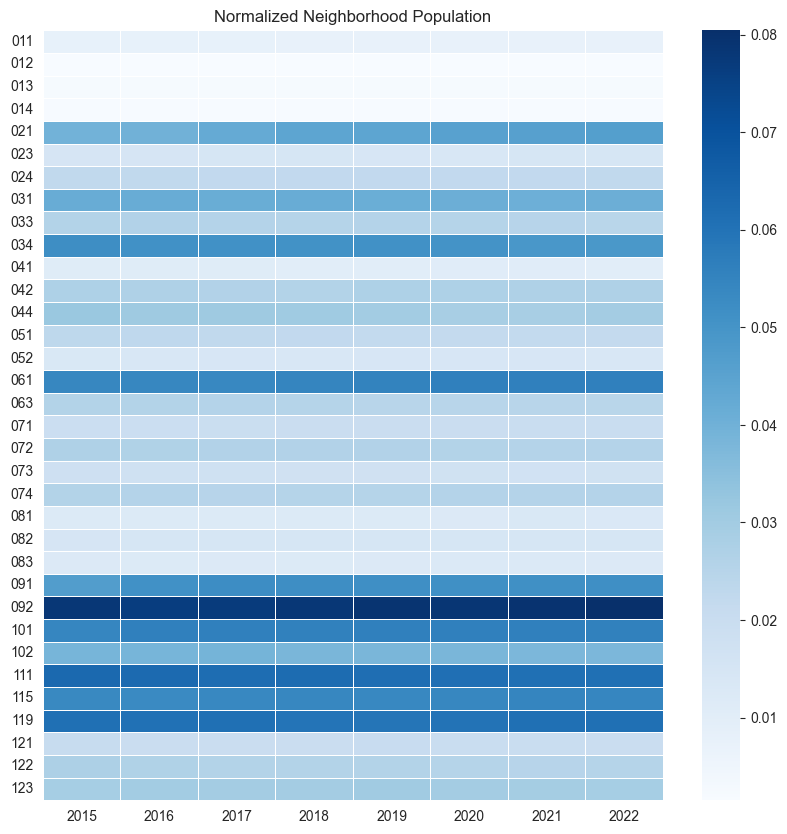

In [51]:
# Do a sum per roster and per neighborhood and display graphically
pop_by_neighborhood = (
    pop_data_filtered.groupby(["roster", "sub_district"])[
        "pop_count"].sum().unstack()
)
pop_data_sub_district_normalized = pop_by_neighborhood.div(
    pop_by_neighborhood.sum(axis=1), axis=0
)
plt.figure(figsize=(10, 10))
# Create the heatmap
pop_heatmap = sns.heatmap(
    pop_data_sub_district_normalized.T,
    cmap="Blues",
    cbar=True,
    linewidths=0.5,
    linecolor="white",
).set(xlabel="", ylabel="")

# Rotate the x-axis labels
plt.xticks(rotation=0)
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title("Normalized Neighborhood Population")

plt.show()

The heat map shows that the proportion of the population within each of the neighborhoods in Zurich stayed approximately the same throughout the years from 2015 to 2022.

In [52]:
# pop_data_filtered
# Chloropleth map of total population
pop_count_pane = pn.pane.HoloViews(hf.get_pop_neighborhood_count)
# Chloropleth map of population density
pop_density_pane = pn.pane.HoloViews(hf.get_pop_density)

# pn.Column(roster_slider, pn.Row(pop_count_pane, pop_density_pane))

In [53]:
# Place the Dog density and population density plots on same page for comparison
pn.Column(
    hf.roster_slider,
    pn.Row(neighborhood_dog_count_pane, dog_density_pane),
    pn.Row(pop_count_pane, pop_density_pane),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'da8db61b-d42c-4487-8e39-c09a5fb4e351': {'version…

#### Comparing the Population and Dog Owner population

With the population data aggregated for every 10 year interval similarly to the dog owners data set we can compare these two datasets to see if any correlation exists between the two (count or density). We can also measure to see if there's any correlation or similarities in the proportions based on the age or the gender of the dog owners and the population or how this has changed year over year

In [54]:
(
    filtered_dog_data.groupby(
        ["roster", "is_male_owner"],
    )["owner_id"]
    .nunique()
    .unstack()
)
filtered_dog_data

,owner_id,is_male_owner,is_male_dog,age_group_10,age_group_20,dog_age,district,sub_district,neighborhood,roster,pet_count,mixed_type,is_pure_breed,breed_type,dog_color_en,breed_2_en,standard,age_group_missing
0,126,True,False,60,60,3,9,092,Altstetten,2015,1,PB,True,K,black/brown,no,welsh terrier,0
1,84431,False,False,70,60,10,7,071,Fluntern,2015,1,PB,True,K,black/tan,no,welsh terrier,0
2,88455,False,True,40,40,15,7,074,Witikon,2015,1,PB,True,K,black red,no,welsh terrier,0
3,101835,False,True,40,40,4,8,082,Mühlebach,2015,1,PB,True,K,Brown black,no,welsh terrier,0
4,108769,True,False,60,60,4,3,031,Alt-Wiedikon,2015,1,PB,True,K,black/tan,no,welsh terrier,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61673,148907,False,True,20,20,0,11,115,Oerlikon,2020,1,BB,False,I,black/brown,white shepherd dog (berger blanc suisse),yugoslavian shepherd dog - sharplanina,0
61674,148907,False,True,20,20,1,11,115,Oerlikon,2021,1,BB,False,I,black/brown,white shepherd dog (berger blanc suisse),yugoslavian shepherd dog - sharplanina,0
61675,148907,False,True,20,20,2,11,115,Oerlikon,2022,1,BB,False,I,black/brown,white shepherd dog (berger blanc suisse),yugoslavian shepherd dog - sharplanina,0
61676,159827,False,True,30,20,2,9,091,Albisrieden,2022,1,BB,False,I,white/black/brown,brandlbracke,pyrenean mountain dog,0


In [55]:
# Compare the gender of the dog Owners for each year
dog_owner_gender_agg = (
    filtered_dog_data.groupby(
        ["roster", "is_male_owner"],
    )["owner_id"]
    .nunique()
    .unstack()
)
# normalize the count by the total dog_owner count per roster
dog_owner_gender_agg_normalized = dog_owner_gender_agg.div(
    dog_owner_gender_agg.sum(axis=1), axis=0
)
# dog_owner_agg_normalized

# Do a aggregated count by subdistrict/neighborhood and roster
filtered_dog_data["sub_district"] = (
    filtered_dog_data["sub_district"].astype(int).astype("string").str.zfill(3)
)
dog_owner_subdistrict = (
    filtered_dog_data.groupby(
        [
            "roster",
            "sub_district",
        ]
    )["owner_id"]
    .nunique()
    .unstack()
)
# Normalized the count by the total count per roster
dog_owner_subdistrict_normalized = dog_owner_subdistrict.div(
    dog_owner_subdistrict.sum(axis=1), axis=0
)
dog_owner_subdistrict_normalized

sub_district,011,012,013,014,021,023,024,031,033,034,041,042,044,051,052,061,063,071,072,073,074,081,082,083,091,092,101,102,111,115,119,121,122,123
roster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,0.009350,0.001109,0.004120,0.002219,0.044057,0.018067,0.025990,0.038986,0.022821,0.032647,0.008241,0.025674,0.021395,0.014422,0.015055,0.036450,0.031537,0.034865,0.033597,0.022187,0.048019,0.016640,0.017433,0.019334,0.041046,0.078130,0.070206,0.030745,0.057369,0.050713,0.058320,0.015531,0.031220,0.022504
2016,0.008772,0.001116,0.004466,0.002392,0.044976,0.017703,0.026156,0.039234,0.023285,0.030941,0.008134,0.026316,0.021053,0.014833,0.016427,0.039075,0.031898,0.033333,0.034450,0.022807,0.048166,0.017065,0.018182,0.018182,0.041308,0.076396,0.069219,0.029027,0.057576,0.051356,0.057097,0.015311,0.030781,0.022967
2017,0.009310,0.001086,0.004189,0.002638,0.043910,0.016912,0.029015,0.035997,0.022653,0.031032,0.007603,0.026532,0.020326,0.015981,0.017843,0.039410,0.032583,0.032273,0.035687,0.021257,0.047944,0.017067,0.017998,0.018309,0.045306,0.073080,0.068580,0.026998,0.060667,0.047789,0.058960,0.015361,0.030256,0.025446
2018,0.010189,0.001349,0.003746,0.001948,0.046299,0.015883,0.028768,0.038508,0.021426,0.031166,0.007042,0.026671,0.020078,0.013036,0.019179,0.038358,0.030267,0.033413,0.034912,0.020977,0.046898,0.016931,0.018729,0.018580,0.048846,0.075217,0.068924,0.026521,0.059185,0.049745,0.058885,0.015133,0.029967,0.023224
2019,0.010253,0.001300,0.003321,0.001444,0.049819,0.016462,0.027148,0.037112,0.021516,0.032491,0.008520,0.023105,0.020361,0.012130,0.020505,0.038845,0.028592,0.032347,0.037256,0.021949,0.045921,0.017473,0.017473,0.018195,0.047653,0.078989,0.069025,0.024838,0.058484,0.050397,0.059350,0.015451,0.029892,0.022383
2020,0.008961,0.001260,0.003220,0.002240,0.048866,0.016942,0.028843,0.037945,0.021983,0.032204,0.007981,0.025343,0.020442,0.011761,0.021703,0.039345,0.028283,0.032764,0.036264,0.021703,0.045926,0.016522,0.019182,0.016662,0.046486,0.076869,0.066928,0.025203,0.057687,0.050126,0.060487,0.015542,0.030524,0.023803
2021,0.009667,0.000890,0.002925,0.001908,0.053040,0.015518,0.029763,0.038794,0.020224,0.032689,0.009031,0.026329,0.018316,0.012465,0.022386,0.041847,0.029636,0.032943,0.035742,0.020351,0.045535,0.016535,0.020987,0.017426,0.046807,0.074917,0.064487,0.025312,0.054057,0.049479,0.059272,0.015009,0.030654,0.025057
2022,0.009570,0.001063,0.002836,0.001181,0.052812,0.016541,0.030600,0.037216,0.020440,0.032491,0.008861,0.026465,0.017958,0.013705,0.022212,0.042651,0.029182,0.032727,0.036980,0.021739,0.044660,0.016777,0.019967,0.016541,0.048795,0.076205,0.063091,0.027292,0.053284,0.051749,0.056829,0.014414,0.028355,0.024811


In [56]:
# print(f"Dog Owner Count by Sub District")
# display(dog_owner_subdistrict)
# print(f"Population Count by Sub District")
# display(pop_by_neighborhood)

In [57]:
# Check the percentage change from the previous year
dog_owner_subdistrict.pct_change(axis=0).fillna(0)

# merge the dog owner count and the population count on the roster and subdistrict
dog_pop_comb_dataset = (
    # dog_data.query("roster < 2023")
    filtered_dog_data.groupby(["roster", "neighborhood", "sub_district"])[["owner_id"]]
    .nunique()
    .merge(
        pop_data_filtered.groupby(["roster", "neighborhood", "sub_district"])[
            ["pop_count"]
        ].sum(),
        left_index=True,
        right_index=True,
    )
)
dog_pop_comb_dataset = dog_pop_comb_dataset.rename(columns={"owner_id": "owner_count"})

dog_pop_comb_dataset["dog_owner_pop_ratio"] = (
    dog_pop_comb_dataset["owner_count"] / dog_pop_comb_dataset["pop_count"]
)

dog_pop_comb_dataset["dog_owner_pop_ratio_pct_change"] = (
    dog_pop_comb_dataset.groupby(["neighborhood", "sub_district"])[
        "dog_owner_pop_ratio"
    ]
    .pct_change(axis=0)
    .fillna(0)
)
dog_pop_comb_dataset.sample(5)

,,,owner_count,pop_count,dog_owner_pop_ratio,dog_owner_pop_ratio_pct_change
roster,neighborhood,sub_district,,,,
2019,Hard,044,141,13057,0.010799,0.060620
2018,Affoltern,111,395,26562,0.014871,-0.004451
2021,Saatlen,121,118,8787,0.013429,0.064394
2022,Hochschulen,012,9,676,0.013314,0.333263
2021,Werd,041,71,4574,0.015523,0.244252


In [58]:
dog_pop_comb_dataset["dog_owner_pop_ratio"].reset_index()

,roster,neighborhood,sub_district,dog_owner_pop_ratio
0,2015,Affoltern,111,0.013993
1,2015,Albisrieden,091,0.013405
2,2015,Alt-Wiedikon,031,0.014340
3,2015,Altstetten,092,0.015407
4,2015,City,014,0.017391
...,...,...,...,...
267,2022,Weinegg,083,0.025193
268,2022,Werd,041,0.016615
269,2022,Wipkingen,102,0.013838
270,2022,Witikon,074,0.033167


In [59]:
dog_pop_comb_dataset.describe().T

hv.HeatMap(
    dog_pop_comb_dataset["dog_owner_pop_ratio"]
    .reset_index()
    .sort_values(by="sub_district", ascending=False),
    kdims=[
        "roster",
        "sub_district",
    ],
    vdims=["dog_owner_pop_ratio", "neighborhood"],
).opts(
    height=800,
    width=500,
    title="Dog Owner to Population Ratio",
    tools=["hover"],
    colorbar=True,
    color_levels=4,
    hooks=[update_xaxis],
    active_tools=["box_zoom"],
)

:HeatMap   [roster,sub_district]   (dog_owner_pop_ratio,neighborhood)

In [ ]:
highlighted_sub_districts = ["074", "071", "052", "072"]
hf.get_line_plots(
    dog_pop_comb_dataset["dog_owner_pop_ratio"].reset_index(),
    x="roster",
    group_by="sub_district",
    highlight_list=highlighted_sub_districts,
).opts(
    height=800,
    width=600,
    legend_cols=2,
    title="Dog Owner to Population Ratio by Sub District",
    hooks=[update_xaxis],
)

In [ ]:
# Create a figure with two subplots and adjust the figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Create the first heatmap for dog ownership
sns.heatmap(
    dog_owner_subdistrict_normalized.T,
    cmap="Blues",
    cbar=False,
    linewidths=2,
    linecolor="white",
    ax=ax1,  # Specify the first subplot as the target
)
ax1.set_title("Dog Ownership Trend in Zurich")
ax1.set(xlabel="", ylabel="")
ax1.title.set_size(16)
ax1.tick_params(axis="both", which="major", labelsize=12)

# Create the second heatmap for population dynamics
sns.heatmap(
    pop_data_sub_district_normalized.T,
    cmap="Blues",
    cbar=True,  # Enable the color bar for the second heatmap
    linewidths=2,
    linecolor="white",
    ax=ax2,  # Specify the second subplot as the target
)
ax2.set_title("Zurich Population Dynamics")
ax2.set(xlabel="", ylabel="")
ax2.title.set_size(16)
ax2.tick_params(axis="both", which="major", labelsize=12)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
custom_palette = sns.color_palette(["pink", "skyblue"])


# Create a figure with two subplots and adjust the figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the first bar plot for dog owners
dog_owner_gender_agg_normalized.plot.barh(
    stacked=True,
    title="More Female than Male Dog Owners",
    ax=ax1,
    color=custom_palette,
    legend=False,
)
ax1.set(xlabel="", ylabel="")
ax1.title.set_size(16)  # Increase title font size
# Increase tick label size
ax1.tick_params(axis="both", which="major", labelsize=12)

# Plot the second bar plot for population
pop_data_agg_normalized.plot.barh(
    stacked=True,
    title="Even Female & Male Population",
    ax=ax2,
    color=custom_palette,
    legend=False,
)
ax2.set(xlabel="", ylabel="")
ax2.title.set_size(16)
ax2.tick_params(axis="both", which="major", labelsize=12)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
pop_data_filtered.info()

In [ ]:
# Group the population count by roster, sub_district, is_male, and age_group_10
pop_count_grouped_4_cols = (
    pop_data_filtered.groupby(["roster", "sub_district", "is_male", "age_group_20"])[
        "pop_count"
    ]
    .sum()
    .reset_index()
)

# Display the grouped population count
pop_count_grouped_4_cols.head()

In [ ]:
filtered_dog_data

In [ ]:
# Group by roster, sub_district, is_male_owner, and age_group_10
grouped_4_cols = filtered_dog_data.groupby(
    ["roster", "sub_district", "is_male_owner", "age_group_20"]
)

# Count the number of dogs and unique owners in each group
dog_count_grouped_4_cols = (
    grouped_4_cols.size()
    .reset_index(name="dog_count")
    .rename(columns={"is_male_owner": "is_male"})
)

dog_owner_grouped_4_cols = (
    grouped_4_cols["owner_id"]
    .nunique()
    .reset_index(name="owner_count")
    .rename(columns={"is_male_owner": "is_male"})
)

In [ ]:
dog_count_grouped_4_cols

##### Merging Population and Dog Owners Data

We grouped `filtered_dog_data` by 'roster', 'sub_district', 'is_male_owner', and 'age_group_20' to form unique groups. 

Two datasets were created:

1. `dog_count_grouped_4_cols`: Contains dog counts per group, calculated using `size`.
2. `dog_owner_grouped_4_cols`: Contains unique owner counts per group, calculated using `nunique` on 'owner_id'.

The 'is_male_owner' column was renamed to 'is_male' for consistency.

These datasets summarize dog and owner counts for further analysis.

In [ ]:
# Merge the grouped population count and dog owner count dataframes
merged_grouped_4_cols = pop_count_grouped_4_cols.merge(dog_owner_grouped_4_cols).merge(
    dog_count_grouped_4_cols
)
# print(merged_grouped_4_cols.isna().sum())
merged_grouped_4_cols["owner_count"] = merged_grouped_4_cols["owner_count"].fillna(
    0)

# Calculate the ratio of dog owners to population for each group
merged_grouped_4_cols["owner_pop_ratio"] = (
    merged_grouped_4_cols["owner_count"] / merged_grouped_4_cols["pop_count"]
)
# Calculate the ratio of dogs to population for each group
merged_grouped_4_cols["dog_pop_ratio"] = (
    merged_grouped_4_cols["dog_count"] / merged_grouped_4_cols["pop_count"]
)
# Drop the Nans rows
merged_grouped_4_cols.dropna(inplace=True)
merged_grouped_4_cols.head(10)

In [ ]:
described_data = merged_grouped_4_cols.groupby(["age_group_20", "sub_district"])[
    ["owner_pop_ratio"]
].describe()

described_data.columns = ["_".join(col)
                          for col in described_data.columns.values]

# Reset the index to make 'age_group_20' and 'sub_district' regular columns
described_data.reset_index(inplace=True)
columns_for_plot = [
    "age_group_20",
    "sub_district",
    "owner_pop_ratio_mean",
    "owner_pop_ratio_50%",
    "owner_pop_ratio_std",
]
described_data = described_data[columns_for_plot].sort_values(
    by=["sub_district"], ascending=False
)
age_group_sub_district_heatmap = hv.HeatMap(
    described_data,
    kdims=["age_group_20", "sub_district"],
    vdims=["owner_pop_ratio_mean", "owner_pop_ratio_50%", "owner_pop_ratio_std"],
).opts(
    height=800,
    width=500,
    line_color="white",
    color_levels=6,
    tools=["hover", "tap"],
    colorbar=True,
    active_tools=["box_zoom"],
    nonselection_fill_alpha=0.5,
    title="Mean Dog Owner to Population Ratio by Age Group and Sub District",
)
described_data
# age_group_sub_district_heatmap

In [ ]:
merged_grouped_4_cols

In [ ]:
# Create a Tap stream on the heatmap
tap_stream = streams.Tap(source=age_group_sub_district_heatmap, y="012", x=40)


@pn.depends(tap_stream.param.x, tap_stream.param.y)
def get_bar_plot_by_age_group_and_sub_district(x, y):
    # Return a message if no location is tapped
    if x is None or y is None:
        return pn.pane.Markdown("No sub district selected")
    else:
        # Convert tapped location to sub_district and age_group
        sub_district = str(y)
        age_group = math.floor(x / 20) * 20
        # Filter dataframe based on sub_district and age_group
        filtered_df = merged_grouped_4_cols.loc[
            (merged_grouped_4_cols["sub_district"] == sub_district)
            & (merged_grouped_4_cols["age_group_20"] == age_group)
        ]
        # Convert is_male column to string
        filtered_df["is_male"] = filtered_df["is_male"].apply(
            lambda x: "Male" if x else "Female"
        )
        # Create bar plot of filtered dataframe
        bar_plot = filtered_df.hvplot.bar(
            x="roster",
            y="owner_pop_ratio",
            title=f"Dog Owner to Population Ratio for {age_group} in {sub_district}",
            xlabel="Year",
            ylabel="Dog Owner to Population Ratio",
            by="is_male",
            width=500,
            height=800,
            stacked=True,
            color=["pink", "skyblue"],
        ).opts(
            active_tools=["box_zoom"],
        )
        # Return bar plot
        return bar_plot


# Create Panel object to display bar plot
bar_panel = pn.pane.HoloViews(get_bar_plot_by_age_group_and_sub_district)
# Display heatmap and bar plot side by side
pn.Row(age_group_sub_district_heatmap, bar_panel)

In [ ]:
# tap_stream = streams.Tap(source=age_group_sub_district_heatmap, y="012", x=50)


# @pn.depends(tap_stream.param.x, tap_stream.param.y)
# def get_bar_plot_by_age_group_and_sub_district(x, y):
#     if x is None or y is None:
#         return pn.pane.Markdown("No sub district selected")
#     else:
#         sub_district = str(y)
#         age_group = math.floor(x / 10) * 10
#         filtered_df = merged_grouped_4_cols.loc[
#             (merged_grouped_4_cols["sub_district"] == sub_district)
#             & (merged_grouped_4_cols["age_group_10"] == age_group)
#         ]
#         filtered_df['is_male'] = filtered_df['is_male'].apply(
#             lambda x: 'Male' if x else 'Female')
#         bar_plot = filtered_df.hvplot.bar(
#             x="roster",
#             y="owner_pop_ratio",
#             title=f"Dog Owner to Population Ratio for {age_group} in {sub_district}",
#             xlabel="Year",
#             ylabel="Dog Owner to Population Ratio",
#             by="is_male",
#             # ylim=(0, 0.3),
#             # rot=90,
#             width=500,
#             height=800,
#             stacked=True,
#             color=['pink', "skyblue"],
#         ).opts(
#             active_tools=["box_zoom"],
#         )
#         return bar_plot


# bar_panel = pn.pane.HoloViews(get_bar_plot_by_age_group_and_sub_district)
# pn.Row(age_group_sub_district_heatmap, bar_panel)

In [ ]:
described_data.loc[
    described_data["sub_district"].isin(highlighted_sub_districts)
].hvplot(
    x="age_group_20",
    y="owner_pop_ratio_mean",
    by="sub_district",
    kind="bar",
    height=600,
    width=1200,
    line_color="white",
    tools=["hover"],
    colorbar=True,
    title=f"Mean Dog Owner to Population Ratio by Age Group and Sub District",
).opts(
    active_tools=["box_zoom"]
)

In [ ]:
# Create boxplot to show distribution of 'owner_pop_ratio' across 'age_group_10'
sns.boxplot(x="age_group_20", y="owner_pop_ratio", data=merged_grouped_4_cols)

plt.title(f"Owner to Population Ratio by Age Group")
plt.show()

In [ ]:
merged_grouped_4_cols.loc[
    merged_grouped_4_cols["sub_district"].isin(highlighted_sub_districts)
]

In [ ]:
# g = sns.FacetGrid(merged_grouped_4_cols, col="age_group_10", row="sub_district")
# g.map(sns.histplot, "owner_pop_ratio")

In [ ]:
merged_grouped_4_cols.query("roster >= 2015 & roster <= 2020").head(20)

In [ ]:
corr = (
    pop_count_grouped_4_cols.merge(dog_owner_grouped_4_cols, how="outer")
    .fillna(0)
    .corr(numeric_only=True)
)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap plot with a color gradient
sns.heatmap(
    corr.mask(mask),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)

# Set the title and labels
ax.set_title("Correlation Matrix")

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
pop_data_filtered.sample().T

#### Zurich Income Dataset
These data contain quantile values of the taxable income of natural persons who are primarily taxable in the city of Zurich. Tax income are in thousand francs (integer).

In [ ]:
# zurich_income_link = "https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv"
zurich_income_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_income.csv"
)
zurich_income_data = pd.read_csv(zurich_income_link)
zurich_income_data.info()

In [ ]:
zurich_income_data = hf.sanitize_df_column_names(zurich_income_data)
zurich_income_data.info()

In [ ]:
zurich_income_data.sample(5)

In [ ]:
# Extract unique values from 'tax_tariff_long' column and convert to list
tax_tariff_long_de = zurich_income_data.tax_tariff_long.unique().tolist()

# Translate the list to a dictionary using a helper function
tax_tariff_long_translated = translate_list_to_dict(tax_tariff_long_de)

# Display the translated dictionary for verification
display(tax_tariff_long_translated)

# Map the translated dictionary to 'tax_tariff_long' column, creating a new 'tax_status' column
zurich_income_data["tax_status"] = zurich_income_data.tax_tariff_long.map(
    tax_tariff_long_translated
)

# Create new columns with copied data for further processing
zurich_income_data["neighborhood"] = zurich_income_data["quar_lang"].copy()
zurich_income_data["roster"] = zurich_income_data["deadline_date_year"].copy()

# Create 'sub_district' column, ensuring it's a string with leading zeros
zurich_income_data["sub_district"] = (
    zurich_income_data["quar_cd"].astype(int).astype("string").str.zfill(3)
)

# Create 'district' column by extracting first two characters from 'sub_district'
zurich_income_data["district"] = zurich_income_data["sub_district"].str[:2].astype(
    int)

# Create new columns for income percentiles
zurich_income_data["median_income"] = zurich_income_data["tax_income_p_50"].copy()
zurich_income_data["lower_q_income"] = zurich_income_data["tax_income_p_25"].copy()
zurich_income_data["upper_q_income"] = zurich_income_data["tax_income_p_75"].copy()

# Define a list of columns of interest for the final dataframe
columns_of_interest_income = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "tax_status",
    "median_income",
    "lower_q_income",
    "upper_q_income",
]

# Create a new dataframe 'income_data' with only the columns of interest
income_data = (
    zurich_income_data[columns_of_interest_income].query(
        "roster >= 2015").copy()
)

# Display the structure of 'income_data' dataframe for verification
income_data.info()
income_data.describe(include="all").T.sort_values(by="unique").fillna("")

In [ ]:
income_data.sample(10)
income_data.to_csv("../data/processed_income_data.csv", index=False)

In [ ]:
income_agg_data_to_merge = (
    income_data.groupby(["roster", "sub_district"])["median_income"]
    .median()
    .reset_index()
)

merged_3_datasets = pd.merge(
    merged_grouped_4_cols.query("roster >= 2015 & roster <= 2020"),
    income_agg_data_to_merge,
    on=["roster", "sub_district"],
    how="left",
)
merged_3_datasets.head(20)

#### Zurich Household data 

In [ ]:
zurich_household_data_link = "https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv"
zurich_household_data_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_household.csv"
)
zurich_household_data = pd.read_csv(zurich_household_data_link)
zurich_household_data.info()

In [ ]:
zurich_household_data = hf.sanitize_df_column_names(zurich_household_data)
zurich_household_data.info()
zurich_household_data.head(5)

In [ ]:
zurich_household_data["neighborhood"] = zurich_household_data["quar_lang"].copy()
zurich_household_data["roster"] = zurich_household_data["key_day_dat_year"].copy()
zurich_household_data["sub_district"] = (
    zurich_household_data["quar_sort"].copy().astype(str).str.zfill(3)
)
zurich_household_data["district"] = (
    zurich_household_data["sub_district"].str[:2].astype(int).copy()
)
zurich_household_data["household_size"] = (
    zurich_household_data["hh_size_sort"].copy().astype(str).str.zfill(2)
)
zurich_household_data["household_count"] = zurich_household_data["number_hh"].copy()
zurich_household_data["resident_count"] = zurich_household_data["number_we"].copy()

# create a dataframe with only the columns of interest
columns_of_interest_household = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "household_size",
    "household_count",
    "resident_count",
]
household_data = zurich_household_data[columns_of_interest_household].query(
    "roster >= 2015 & roster <= 2020"
)

household_data.info()
household_data.head(10)

In [ ]:
household_data.describe(include="all").T.sort_values(by="unique").fillna("")

In [ ]:
# Calculate total residents per sub_district
household_data["total_residents"] = household_data.groupby(["roster", "sub_district"])[
    "resident_count"
].transform("sum")

# Calculate the total households per sub_district
household_data["total_households"] = household_data.groupby(["roster", "sub_district"])[
    "household_count"
].transform("sum")

# Average household size
household_data["avg_household_size"] = (
    household_data["total_residents"] / household_data["total_households"]
)

# Calculate weighted average household size
household_data["resident_portion"] = (
    household_data["resident_count"] / household_data["total_residents"]
)
# household_data

hh_data_to_merge = (
    household_data.groupby(["roster", "sub_district"])[
        ["avg_household_size", "total_households"]
    ]
    .mean()
    .reset_index()
)

In [ ]:
# Save the proprocessed housing data to csv
hh_data_to_merge.to_csv("../data/processed_household_data.csv", index=False)

Reload household dataset that was proprocessed

In [ ]:
# load the processed housing data
hh_data_to_merge = pd.read_csv("../data/processed_household_data.csv")
hh_data_to_merge["sub_district"] = (
    hh_data_to_merge["sub_district"].astype(int).astype(str).str.zfill(3)
)
hh_data_to_merge["total_households"] = hh_data_to_merge["total_households"].astype(
    int)
hh_data_to_merge.info()
hh_data_to_merge.head()

In [ ]:
merged_4_datasets = pd.merge(
    merged_3_datasets,
    hh_data_to_merge,
    on=["roster", "sub_district"],
    how="left",
)


merged_4_datasets.info()

##### Local Indicators of Spatial Association (LISA)
This LISA plot shows spatial autocorrelation of number of dog owners per sub-district in 2020. Quadrants represent:

1. High-High (HH): "Hot spots" of high dog ownership.
2. Low-Low (LL): "Cold spots" of low dog ownership.
3. High-Low (HL) and Low-High (LH): "Spatial outliers" of contrasting dog ownership.

Areas with p-value < 0.05 are statistically significant and highlighted. This reveals spatial distribution and clustering of dog owners across sub-districts.

In [ ]:
merged_4_datasets.head()
# neighborhood_gdf
# merged_gdf
# gpd.read_file("../data/zurich_neighborhoods.geojson").info()


# lps.weights.Queen.from_dataframe(neighborhood_gdf, use_index=False).neighbors

In [ ]:
def calculate_lisa_values(
    df, roster, geodataframe, agg_level, attribute, agg_func="sum", show_plot=True
):
    df_filtered = df.query(f"roster == {roster}")
    df_grouped = df_filtered.groupby(agg_level)[attribute].agg(agg_func)

    n_gdf = geodataframe.set_index(agg_level).sort_index()
    n_gdf = n_gdf.merge(df_grouped, left_index=True,
                        right_index=True, how="left")
    # Find the density of the attribute by dividing by the area
    att_density = f"{attribute}_density"
    n_gdf[att_density] = n_gdf[attribute] / n_gdf["area_km2"]

    w = lps.weights.Queen.from_dataframe(n_gdf, use_index=True)
    w.transform = "r"

    # y = (n_gdf[att_density] - n_gdf[att_density].mean()) / n_gdf[att_density].std()
    y = n_gdf[att_density]

    li = Moran_Local(y, w)
    if show_plot:
        plot_local_autocorrelation(
            li, n_gdf, att_density, p=0.05, aspect_equal=True)
        plt.suptitle(f"Local Moran's I for {att_density} in {roster}")
    return li.Is, li.p_sim, n_gdf


df_for_spatial_analysis = merged_4_datasets[
    ["roster", "sub_district", "owner_count", "pop_count", 'dog_count']
]
attributes = ["owner_count", "pop_count", 'dog_count']
rosters = df_for_spatial_analysis.roster.unique()

results = {
    f"{attribute}_density_{roster}": calculate_lisa_values(
        df_for_spatial_analysis,
        roster,
        gpd.read_file("../data/zurich_neighborhoods.geojson"),
        "sub_district",
        attribute,
        # show_plot=False,
    )
    for roster in rosters
    for attribute in attributes
}
# Create a DataFrame of global Moran's I values

# Display the DataFrame

lisa_df = pd.DataFrame({key: value[0]
                       for key, value in sorted(results.items())})

lisa_df.index = list(results.values())[0][2].index
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(lisa_df, cmap="RdBu_r", ax=ax, center=0)
# plt.title(f"Local Moran's I for Density of Attributes by Sub-District")
# plt.show()

lisa_df.hvplot.heatmap(
    cmap="RdBu_r",
    symmetric=True,
    height=700,
    width=1000,
    title="Owner Count Density || Population Count Density",
    xaxis='bare',
).opts(active_tools=["box_zoom"], color_levels=7)

In [ ]:
print(f"{df_for_spatial_analysis.describe()=}")
# merged_4_datasets

In [ ]:
hf.get_line_plots(
    merged_4_datasets.groupby(["roster", "sub_district"])["owner_count"]
    .sum()
    .reset_index(),
    x="roster",
    group_by="sub_district",
    highlight_list=highlighted_sub_districts,
).opts(
    height=800,
    width=600,
    legend_cols=2,
    title="Owner Count by Sub District",
    hooks=[update_xaxis],
)

In [ ]:
from sklearn.linear_model import LinearRegression

pop_owner_agg = merged_4_datasets.groupby(["roster", "sub_district"], as_index=False)[
    ["pop_count", "owner_count"]
].sum()
sns.regplot(x="roster", y="owner_count", data=pop_owner_agg)
plt.title(f"Seaborn Regression Plot | Owner Count")
plt.show()


# Create a linear regression model
model = LinearRegression()

# Reshape the data to fit the model
X = pop_owner_agg["roster"].values.reshape(-1, 1)
y = pop_owner_agg["owner_count"].values

# Fit the model
model.fit(X, y)

# fit trend
y_pred = model.predict(X)

# Get the coefficients
slope = model.coef_[0]
intercept = model.intercept_

In [ ]:
# plot the regression line and the actual data
pop_owner_agg.plot.scatter(x="roster", y="owner_count")
plt.plot(X, y_pred, color="red")
plt.xlabel("Year")
plt.ylabel("Owner Count")
plt.title("Owner Count Trend")
plt.show()

In [ ]:
# Aggregate the pop_count and owner_count by roster and sub_district
pop_owner_agg = merged_4_datasets.groupby(["roster", "sub_district"], as_index=False)[
    ["pop_count", "owner_count"]
].sum()
pop_owner_agg["roster"] = pd.to_datetime(
    pop_owner_agg["roster"].astype("string"), format="%Y"
)
pop_owner_agg["roster"]

In [ ]:
merged_no_age = (
    merged_4_datasets.groupby(["roster", "sub_district"], as_index=False)[
        ["pop_count", "owner_count", "dog_count"]
    ]
    .sum()
    .merge(
        merged_4_datasets.groupby(["roster", "sub_district"], as_index=False)[
            ["median_income", "avg_household_size", "total_households"]
        ].mean()
    )
)
# Create dog to owner ratio column
merged_no_age["dog_owner_ratio"] = (
    merged_no_age["dog_count"] / merged_no_age["owner_count"]
)
merged_no_age_area = merged_no_age.merge(
    neighborhood_gdf[["sub_district", "area_km2"]], on="sub_district", how="left"
)
merged_no_age_area["dog_density"] = (
    merged_no_age_area["dog_count"] / merged_no_age_area["area_km2"]
)
merged_no_age_area["owner_density"] = (
    merged_no_age_area["owner_count"] / merged_no_age_area["area_km2"]
)
merged_no_age_area["pop_density"] = (
    merged_no_age_area["pop_count"] / merged_no_age_area["area_km2"]
)
merged_no_age_area.sample().T
merged_no_age_area.describe().T

In [ ]:
df_for_spatial_analysis = merged_4_datasets[["roster", "sub_district", "owner_count"]]


lisa_df = pd.DataFrame()


for roster in [2020]:
    df = df_for_spatial_analysis.query(f"roster == {roster}")

    df = df.groupby("sub_district")["owner_count"].sum()

    # df = df.set_index("sub_district")

    n_gdf = neighborhood_gdf.set_index("sub_district")

    n_gdf = n_gdf.merge(df, left_index=True, right_index=True, how="left")

    w = lps.weights.Queen.from_dataframe(n_gdf, use_index=False)

    w.transform = "r"

    # Standardize the attribute

    y = (n_gdf["owner_count"] - n_gdf["owner_count"].mean()) / n_gdf[
        "owner_count"
    ].std()

    li = Moran_Local(y, w)

    plot_local_autocorrelation(li, n_gdf, "owner_count", p=0.05, aspect_equal=True)

    # Save the LISA values in the DataFrame

    lisa_df[roster] = li.Is

    # Set the index of the DataFrame to be the sub-districts

    lisa_df.index = n_gdf.index



lisa_df

In [ ]:
# dog_data["age_group_10"] = pd.Categorical(dog_data["age_group_10"], ordered=True)


# dog_data["age_group_10"].cat.categories


# dog_data["roster"] = dog_data["roster"].astype(str)


# dog_data["roster"] = pd.Categorical(dog_data["roster"], ordered=True)


# dog_data["roster"].cat.categories

In [ ]:
dog_data.sample()
zurich_income_data.loc[zurich_income_data["roster"] > 2014][
    ["tax_status", "tax_income_p_50", "district", "sub_district", "roster"]
]
tax_status_button = pnw.RadioButtonGroup(
    name="Tax Status",
    options=list(zurich_income_data["tax_status"].unique()),
    value="Basic tariff",
    button_style="outline",
    button_type="success",
)
roster_button = pnw.RadioButtonGroup(
    value=2018,
    options=list(range(2015, 2021)),
    button_style="outline",
    button_type="success",
)


@pn.depends(roster_button.param.value, tax_status_button.param.value)
def get_income_polygon(roster, tax_status):
    df = zurich_income_data.loc[
        (zurich_income_data["roster"] == roster)
        & (zurich_income_data["tax_status"] == tax_status)
    ][["roster", "tax_status", "tax_income_p_50", "sub_district"]]

    income_gdf = neighborhood_gdf.merge(df, on="sub_district")
    # income_gdf = income_gdf.drop(columns=["km2"])

    income_cmap = list(sns.color_palette(
        "light:" + "#008800", n_colors=6).as_hex())
    return gv.Polygons(income_gdf).opts(
        **poly_opts,
        color="tax_income_p_50",
        # fill_alpha=0,
        cmap=income_cmap,
        clim=(30, 100),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{tax_status.title()} | {roster}",
    )


income_chloropleth = pn.pane.HoloViews(get_income_polygon)

pn.Column(tax_status_button, roster_button, get_income_polygon)

In [ ]:
unique_breeds = dog_data["standard"].unique()
num_unique_breeds = len(unique_breeds)

# Repeat the colormap to cover all unique breeds
repeated_cmap = list(cc.glasbey_dark) * (num_unique_breeds // len(cc.glasbey_dark) + 1)

# Explicit mapping for the color to use for each standard breed
explicit_mapping = {breed: repeated_cmap[i] for i, breed in enumerate(unique_breeds)}
my_colors = hv.Cycle(list(explicit_mapping.values()))


# colormaps for the the gender
boy_cmap = list(sns.color_palette("light:#00008b", n_colors=6).as_hex())


girl_cmap = list(sns.color_palette("light:#8b008b", n_colors=6).as_hex())

In [ ]:
neighborhood_gdf["km2"] = neighborhood_gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6



neighborhood_gdf["km2"] = neighborhood_gdf["km2"].round(2)



districts_gdf["km2"] = districts_gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6



districts_gdf["km2"] = districts_gdf["km2"].round(2)



districts_gdf

In [ ]:
hv.opts.defaults(
    hv.opts.HeatMap(
        tools=["hover", "tap", "box_select"],
        active_tools=["box_zoom"],
        width=800,
        height=500,
        ylabel="",
        line_color="white",
        line_width=2,
        toolbar="above",
        selection_line_color="red",
        nonselection_alpha=0.9,
        nonselection_line_color="white",
    )
)

poly_opts = dict(
    width=800,
    height=500,
    line_width=2,
    xaxis=None,
    yaxis=None,
    aspect="equal",
    # cmap=explicit_mapping,
    # projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=500,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",
    xlabel="",
    cmap=explicit_mapping,
    show_legend=False,
    active_tools=["box_zoom"],
)

In [ ]:
tools_opts = dict(active_tools=["box_zoom"], toolbar="above")
# bar plot of the owner age distribution
owner_age_groups_all = (
    dog_data.groupby(["age_group_10", "roster"])
    .size()
    .unstack()
    .rename(columns={0: "Count"})
    .hvplot.bar(
        xlabel="",
        rot=90,
        legend=True,
        tools=["hover", "box_select"],
        title="Owners Age distribution",
        muted_line_alpha=0.01,
    )
    .opts(**tools_opts)
)
# kde plot of the dog age distribution
dog_age_all = dog_data.hvplot.kde(
    y="dog_age",
    by="roster",
    xlim=(0, 21),
    ylim=(0, 0.1),
    xlabel="",
    legend=True,
    tools=["hover", "box_select"],
    title="Dog Age Density distribution",
    muted_alpha=0.01,
).opts(**tools_opts)
# step plot of the dog age distribution
dog_age_all_step = (
    dog_data.groupby(["dog_age", "roster"])
    .size()
    .hvplot.step(
        x="dog_age",
        by="roster",
        xlim=(0, 21),
        title="Dog Age distribution",
    )
    .opts(**tools_opts)
)
# panel card with the 3 plots
all_ages_card = pn.Card(
    # add spacer
    pn.Spacer(height=70),
    dog_age_all_step,
    dog_age_all,
    owner_age_groups_all,
    title="Age Distribution for ALL Dogs and Owners",
    styles={"background": "gainsboro"},
)

In [ ]:
pn.state.kill_all_servers()
all_ages_card

In [ ]:
def plot_age_range_stats(df, breed, bw, is_pure_breed):
    """Function to plot the age_range stats for the breed owners and the dog age distribution"""
    if is_pure_breed:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False) & is_pure_breed == True'
        )
    else:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    # plot a step plot of the dog_age
    step = (
        breed_df.groupby(["dog_age", "roster"])
        .size()
        .unstack()
        .hvplot.step(
            title=f"Dog Age distribution | {breed.title()}",
            shared_axes=False,
            muted_alpha=0.1,
        )
    )

    # plot age_range of breed_df kde plot
    kde = breed_df.hvplot.kde(
        y="dog_age",
        by="roster",
        bandwidth=bw,
        xlim=(0, 20),
        ylim=(0, None),
        xlabel="",
        muted_alpha=0.01,
        title=f"Dog Age density distribution | {breed.title()}",
    )
    # plot age_range of breed_df bar plot

    bar = (
        breed_df.groupby(["age_group_10", "roster"])
        .size()
        .unstack()
        .hvplot.bar(
            rot=90,
            legend=True,
            tools=["hover", "box_select"],
            title=f"Owner Age distribution | {breed.title()} ",
            shared_axes=False,
            xlabel="",
        )
        .opts(active_tools=["box_select"])
    )
    return (step + kde + bar).cols(1)


# create widgets for the breed, bandwidth
breed_selector = pnw.Select(name="Breed", options=topn, value="french bulldog")
top_n_slider = pnw.IntSlider(name="Top N", start=1, end=30, step=1, value=10, width=200)
bandwidth_slider = pnw.FloatSlider(
    name="Bandwidth", start=0.1, end=2, step=0.1, value=0.5, width=200
)
pure_breed_checkbox = pnw.Checkbox(name="Pure Breed", value=True, width=200)
is_male_owner_checkbox = pnw.Checkbox(name="Male Dog Owner", value=True, width=200)
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"],
    name="Roster",
    width=200,
)
show_labels_checkbox = pnw.Checkbox(name="Show Annotations", value=True, width=200)


# create a dynamic map

dynamic_age_plot = pn.bind(
    plot_age_range_stats,
    df=dog_data,
    breed=breed_selector,
    bw=bandwidth_slider,
    is_pure_breed=pure_breed_checkbox,
)
widget_controls = pn.Row(
    pure_breed_checkbox,
    breed_selector,
    bandwidth_slider,
    styles={"background": "mintcream"},
)
dynamic_age_card = pn.Card(
    widget_controls,
    dynamic_age_plot,
    title="Age Distribution of Dog and Owners by Breeds",
    styles={"background": "mintcream"},
)

In [ ]:
# pn.Column(dynamic_age_card).show()
districts_gdf = districts_gdf.dissolve(by="district")
districts_gdf
# dog_data
# dynamic_age_card

In [ ]:
filtered_dog_data

In [ ]:
pn.state.kill_all_servers()


# get the count of the french bulldog in each district for each roster and plot it
# plot it on a dynamic map with a slider for the roster
def get_breed_count(breed, roster):
    df = filtered_dog_data[
        (filtered_dog_data["standard"] == breed)
        & (filtered_dog_data["roster"] == roster)
    ][["district", "standard", "roster"]]
    df = df.groupby("district").size().reset_index(name="count")
    df = df.set_index("district")

    breed_gdf = districts_gdf.merge(
        df, left_index=True, right_index=True, how="left")
    # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
    breed_color = explicit_mapping[breed]
    # Start from white and go to the breed color
    breed_cmap = list(sns.color_palette(
        "light:" + breed_color, n_colors=6).as_hex())
    return gv.Polygons(breed_gdf).opts(
        **poly_opts,
        color="count",
        # fill_alpha=0,
        cmap=breed_cmap,
        clim=(0, 50),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{breed.title()} | {roster}",
    )


standard_selector = pnw.Select(
    name="Breed", options=topn, value="french bulldog")
# create the dynamic map
breed_chloro = gv.DynamicMap(
    pn.bind(get_breed_count, breed=standard_selector, roster=roster_button)
)

In [ ]:
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")
pn.Column(standard_selector, pn.Row(roster_button, breed_chloro)).show()
# breed_chloro

In [ ]:
pn.state.kill_all_servers()


neighborhood_poly = gv.Polygons(neighborhood_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="crimson",
    # fill_color="lightgray",
    # fill_alpha=0,
    alpha=0.2,
)
neighborhood_poly

pn.pane.HoloViews(breed_chloro)

In [ ]:
neighborhood_poly.data
breed_chloro.data

In [ ]:
districts_gdf = (
    neighborhood_gdf.dissolve(by="district")
    .drop(columns=["neighborhood", "sub_district"])
    .reset_index()
)

districts_poly = gv.Polygons(districts_gdf).opts(
    **poly_opts,
    color_index=None,
)

# (district_poly * neighborhood_poly).opts(title="Zurich Districts and Neighborhoods")

In [ ]:
zurich_desc_path = "../data/zurich_districts.csv"
zurich_desc = pd.read_csv(zurich_desc_path)
# zurich_desc["district"] = zurich_desc["district"].astype(str).str.zfill(2)
districts_gdf["district"] = districts_gdf["district"].astype(int)

districts_gdf = districts_gdf.merge(
    zurich_desc[["district", "desc", "district_name"]], on="district", how="left"
)
# districts_gdf.set_index("district", inplace=True)
districts_poly = gv.Polygons(districts_gdf)

In [ ]:
districts_gdf = districts_gdf.dissolve(by="district")
districts_poly = gv.Polygons(districts_gdf)

In [ ]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=districts_poly)


def display_info(index):
    if not index:
        return pn.pane.Markdown("No district selected")
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        return pn.pane.Markdown(
            f"#### {dnum}\n ### {dname}\n {ddesc}",
        )


def display_wordcloud(index, breed):
    breed_color = explicit_mapping[breed]
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud))
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = districts_poly.iloc[index[0]].data["geometry"].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        width = maxx - minx
        height = maxy - miny

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new("1", (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test) * 255,
            color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            # toolbar=None,
        )


layout = pn.Column(
    pn.bind(display_wordcloud, select_district.param.index, breed=breed_selector),
    districts_poly * breed_chloro,
    pn.bind(display_info, select_district.param.index),
    width=800,
)

breed_chloro_card = pn.Card(
    roster_slider, layout, title="Chloropleth of Selected Breed"
)

In [ ]:
dynamic_age_card

In [ ]:
pn.Row(
    dynamic_age_card,
    breed_chloro_card,
    all_ages_card,
    sizing_mode="stretch_width",
)

Gender Heatmap


In [ ]:
# Create a Tap stream linked to the HeatMap
breed_tap = streams.Tap(source=None)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_gender_roster_df(roster, gender):
    return dog_data.loc[
        (dog_data["is_male_owner"] == gender) & (dog_data["roster"] == roster)
    ]


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_top_n_gender_breeds(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    return gender_roster_df["standard"].value_counts().head(top_n).index.tolist()


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_gender_heatmap(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    topn_gender_breeds = get_top_n_gender_breeds(
        roster=roster, gender=gender, top_n=top_n
    )

    top_gender_breeds_df = (
        gender_roster_df.loc[gender_roster_df["standard"].isin(
            topn_gender_breeds)]
        .groupby(["standard", "district"])
        .size()
        .fillna(0)
        .reset_index(name="count")
    )
    sex = "Male" if gender else "Female"
    top_gender_breeds_heatmap = hv.HeatMap(
        top_gender_breeds_df, ["district", "standard"], "count"
    ).redim(standard="gender_standard")
    top_gender_breeds_heatmap.opts(
        height=(33 * top_n) + 50,
        cmap=boy_cmap if gender else girl_cmap,
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top {top_n} breeds | {roster} | {sex} Owners",
        clim=(0, 50),
    )
    breed_tap.source = top_gender_breeds_heatmap

    return top_gender_breeds_heatmap


dynamic_gender_heatmap_panel = pn.pane.HoloViews(get_gender_heatmap)

# pn.Column(
#     roster_slider,
#     holder_gender_checkbox,
#     top_n_slider,
#     dynamic_gender_heatmap_panel,
# ).show()

In [ ]:
@pn.depends(
    breed_tap.param.x,
    breed_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def get_breed_chloropleth(x, y, roster, gender):
    if x is None or y is None:
        return gv.Polygons(districts_gdf).opts(**poly_opts, title="Select a cell")
    else:
        data = get_gender_roster_df(roster=roster, gender=gender)
        data = data.loc[data["standard"] == y]
        data = data.groupby("district").size().reset_index(name="count")
        data = data.set_index("district")

        breed_gdf = districts_gdf.merge(
            data, left_index=True, right_index=True, how="left"
        )
        # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
        breed_gdf.fillna(0, inplace=True)
        breed_color = explicit_mapping[y]
        breed_cmap = list(
            sns.color_palette("light:" + breed_color, n_colors=6).as_hex()
        )
        sex = "Male" if gender else "Female"

        return gv.Polygons(breed_gdf).opts(
            **poly_opts,
            color="count",
            cmap=breed_cmap,
            clim=(0, 50),
            colorbar=True,
            line_color="darkgray",
            tools=["hover", "tap", "box_select"],
            title=f"{y.title()} | {roster} | {sex} Owners",
        )


breed_chloropleth = pn.pane.HoloViews(get_breed_chloropleth)


# Combine the heatmap and the text display into a layout
layout = pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    top_n_slider,
    dynamic_gender_heatmap_panel,
    breed_chloropleth,
)

# layout.show()

In [ ]:
# Define a Tap stream linked to the owner age group
owner_tap = streams.Tap(source=None, x=1, y=30)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_age_heatmap(roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    data_grouped = (
        data.groupby(["district", "age_group_10"])["owner_id"]
        .nunique()
        .reset_index()
        .rename(columns={"owner_id": "count"})
    )
    sex = "Male" if gender else "Female"
    heatmap = hv.HeatMap(data_grouped, ["district", "age_group_10"], "count")

    heatmap.opts(
        # **heatmap_opts,
        cmap=boy_cmap if gender else girl_cmap,
        ylim=(0, 100),
        xlim=(0, 13),
        colorbar=True,
        active_tools=["box_zoom"],
        tools=["hover", "tap", "box_select"],
        title=f"{sex} Dog Owners | {roster} | by Age Group vs District",
    )
    owner_tap.source = heatmap
    return heatmap


age_group_panel = pn.pane.HoloViews(get_age_heatmap)

In [ ]:
dog_data["age_group_10"].cat.categories

In [ ]:
import math

pn.state.kill_all_servers()
# Bar Plot which shows the top 10 breeds for each district and age group as it is selected in the heatmap

bar_plots_opts = dict(
    height=500,
    width=800,
    invert_axes=True,
    cmap=explicit_mapping,
    show_legend=False,
    xlabel="",
    fontscale=1.2,
)


@pn.depends(
    owner_tap.param.x,
    owner_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def update_barplot(x, y, roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    if x is None or y is None:
        bar_data = (
            data["standard"]
            .value_counts()
            .head(10)
            .rename("count")
            .reset_index()
            .rename(columns={"index": "standard"})
        )
        return hv.Bars(bar_data, kdims=["standard"], vdims="count").opts(
            **bar_plots_opts,
            color="standard",
            title=f"Top 10 Breeds",
            tools=["hover"],
            active_tools=["box_zoom"],
        )
    x = math.ceil(x - 0.5)
    y = math.ceil(y / 10) * 10
    bar_data = (
        data.loc[(data["district"] == x) & (
            data["age_group_10"] == y)]["standard"]
        .value_counts()
        .head(10)
        .reset_index()
    )
    bar_data.columns = ["standard", "count"]
    if len(bar_data) == 0:
        return hv.Bars([], "standard", "count").opts(
            **bar_plots_opts,
            title=f"No Breeds for Age-group:{y} | Districts:{x}",
            active_tools=["box_zoom"],
        )

    return hv.Bars(bar_data, "standard", "count").opts(
        **bar_plots_opts,
        color="standard",
        title=f"Top {min(10,len(bar_data))} Popular Breeds | Age-group:{y} | Districts:{x}",
        active_tools=["box_zoom"],
    )


update_barplot_panel = pn.pane.HoloViews(update_barplot)
pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    age_group_panel,
    update_barplot_panel,
)